## OCNT-DMSLIB-1 DMS Assay Run #8: Protocol Comparisons

| ID | Protocol | Condition | Concentration (M) | Replicates
| --- | --- | -------- | --- | ----------- |
| 1 | A | None | 0 | 4 |
| 2 | A | IFN-alpha (100 U/mL) | 0 | 4 |
| 3 | A | BMS-986202 + IFN-alpha (100U/mL) | 2e-8 | 4 |
| 4 | B | None | 0 | 4 |
| 5 | B | IFN-alpha (100 U/mL) | 0 | 4 |
| 6 | B | BMS-986202 + IFN-alpha (100U/mL) | 2e-8 | 4 |

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Protocol Comparisons](#part4)
5. [Potentiation Comparisons](#part5)

In [2]:
library(magrittr)
library(data.table)
library(ggrepel)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(ggbeeswarm)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2),
               drug = drug.x,
               conc = conc.x) %>%
        select(drug, conc, pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-1-assay-run8-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

make_profile <- function(poss, df){
    
    p1 <- df %>%
        filter(pos == poss) %>%
        ggplot() +
            geom_pointrange(aes(x = aa, y = estimate, color = condition,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error),
                            position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16) +
            geom_hline(yintercept = 0) + ggtitle(poss) +
            scale_color_manual(values = c("red", "black"))

    return(p1)
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [3]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run8/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon", "chunkGrp",
                                        "dox", "condition", "condition_conc","clone"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

Rows: 15877439 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): sample, barcode, lib, chunk, wt_aa, mut_aa, wt_codon, mut_codon, c...
dbl  (4): count, pos, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


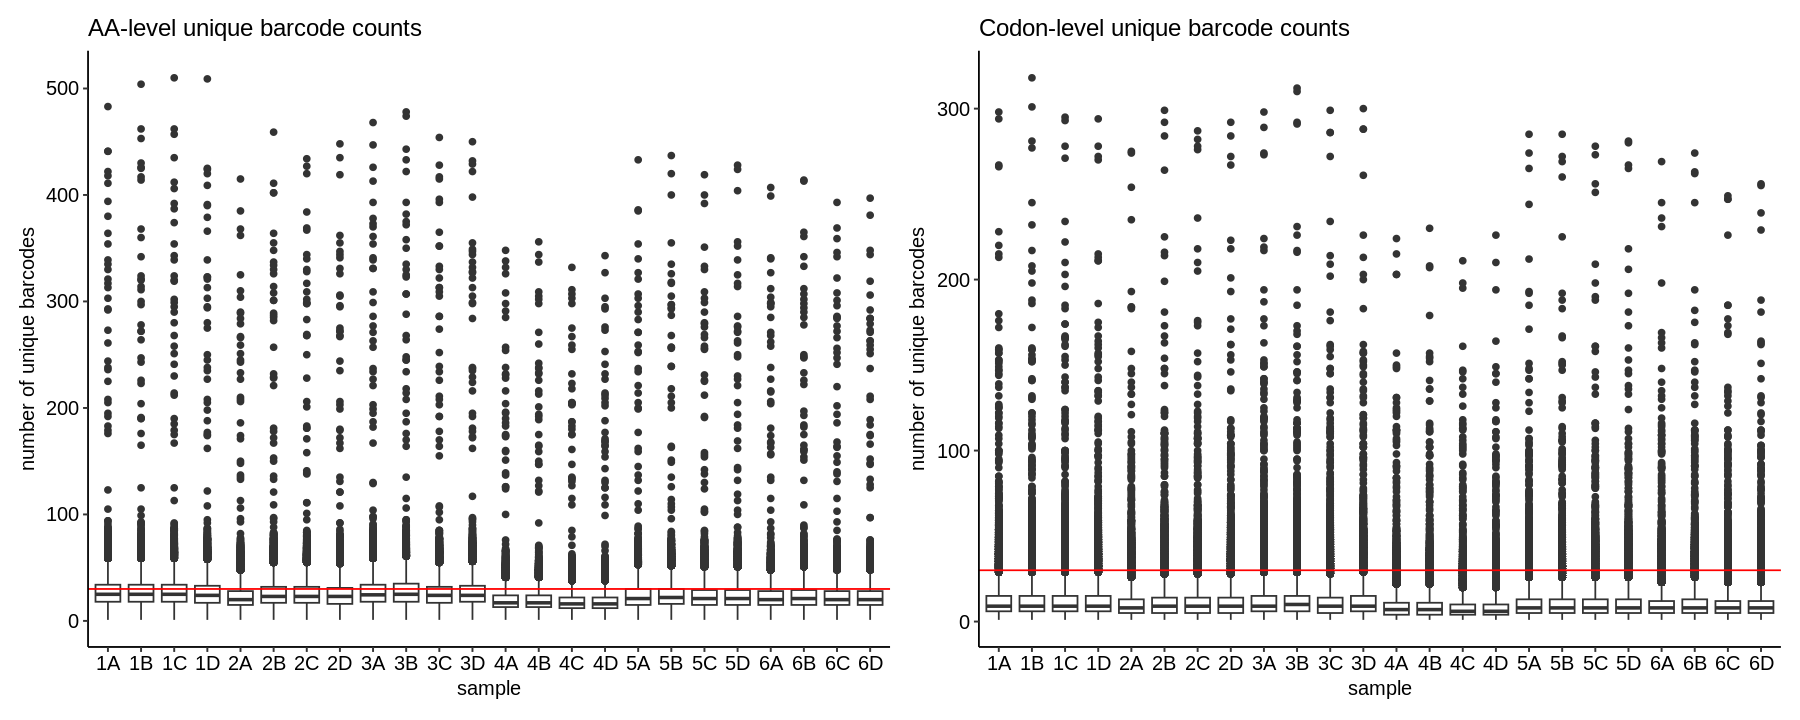

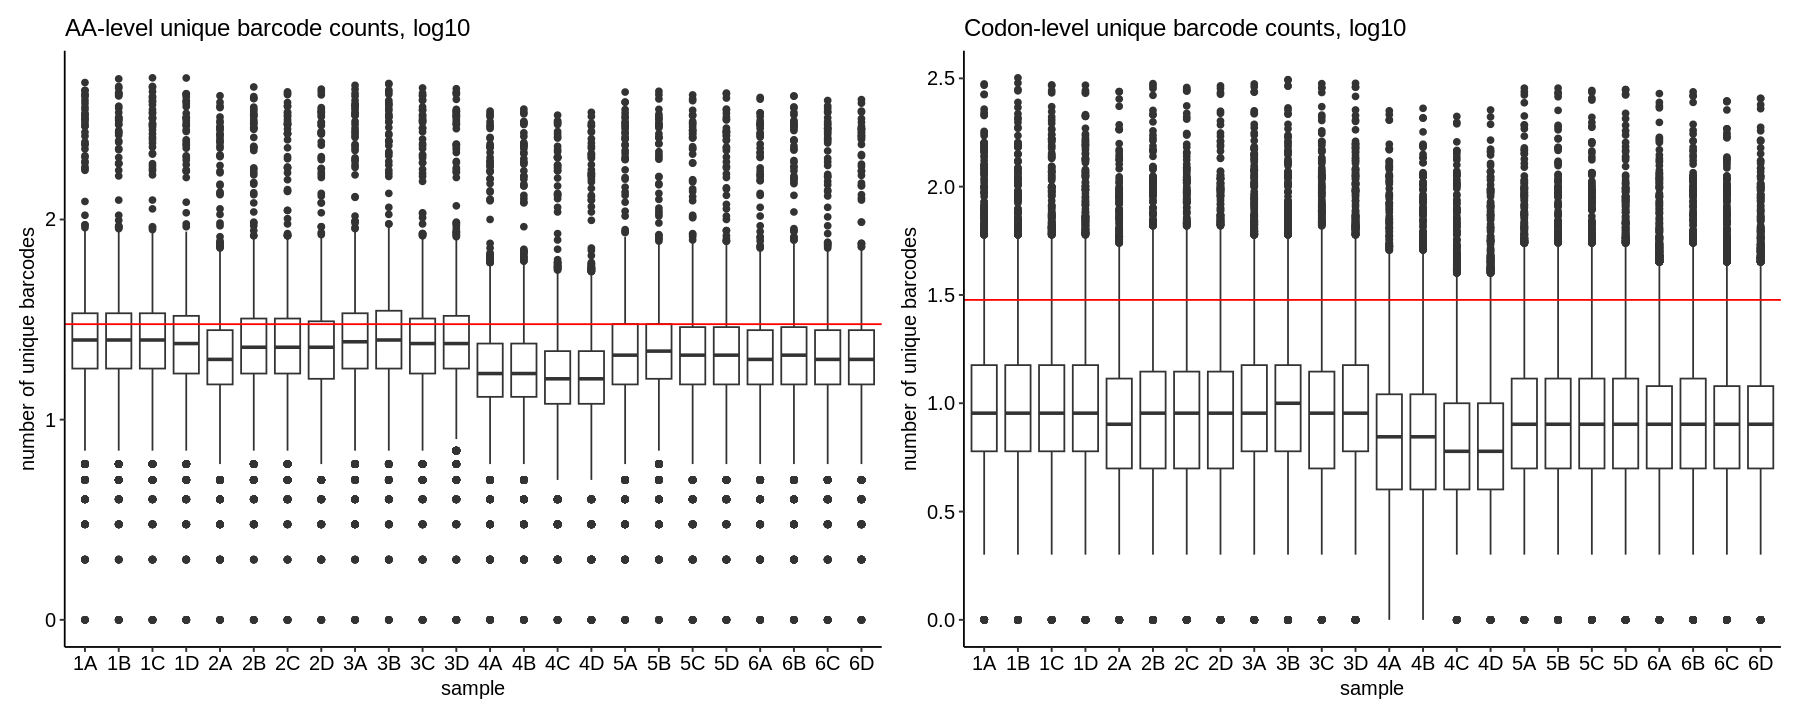

In [4]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using sample `1A` only; the remaining plots can be found [here](./coverage-plots):

In [6]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with

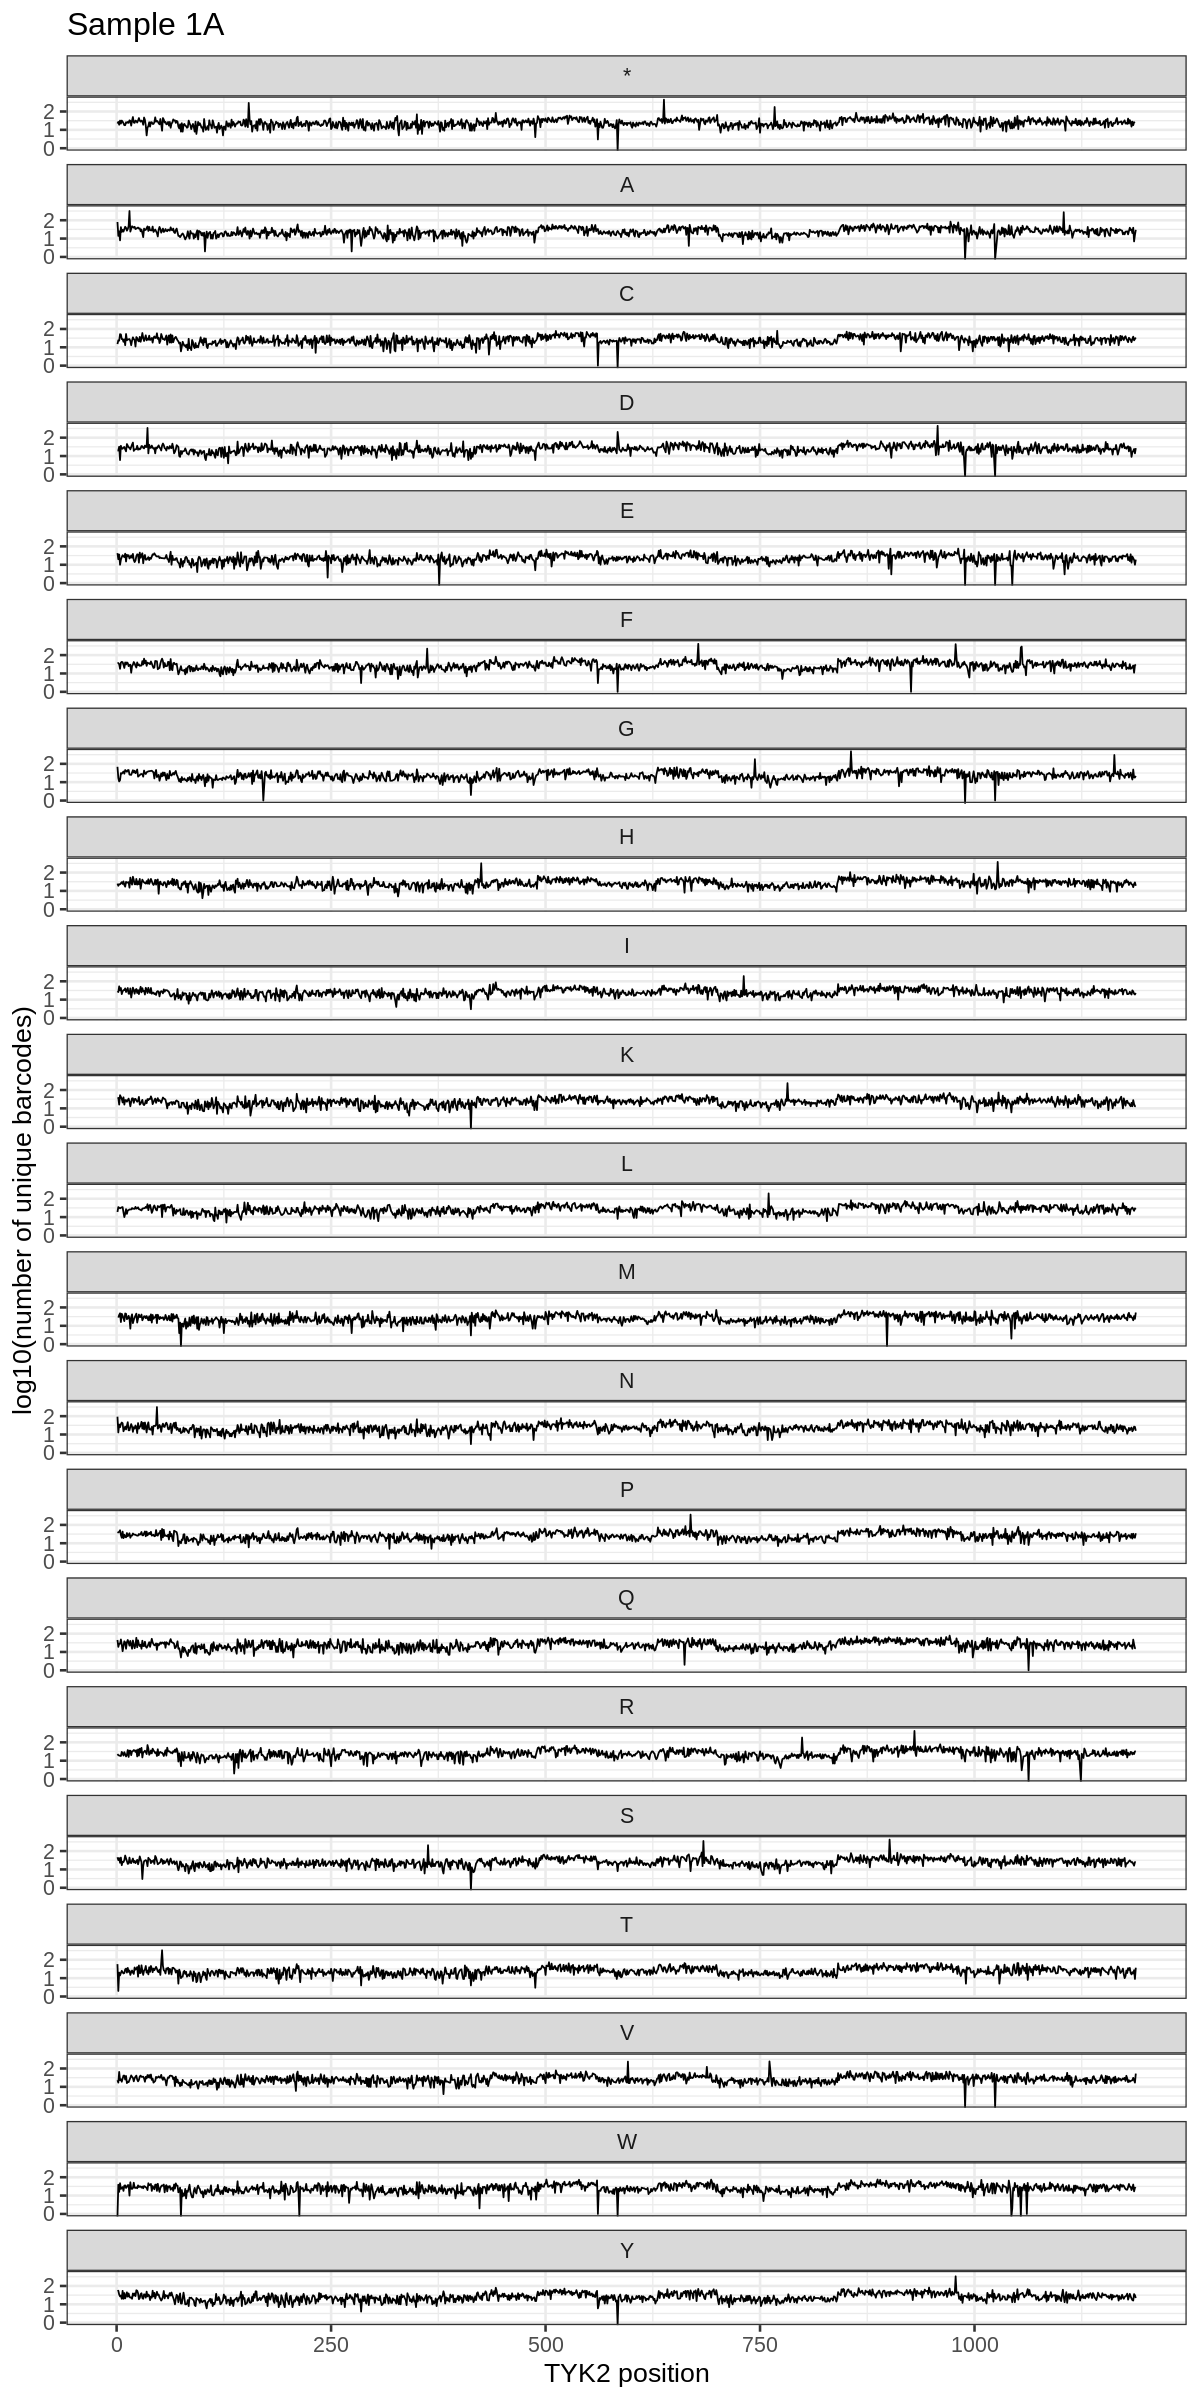

In [11]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

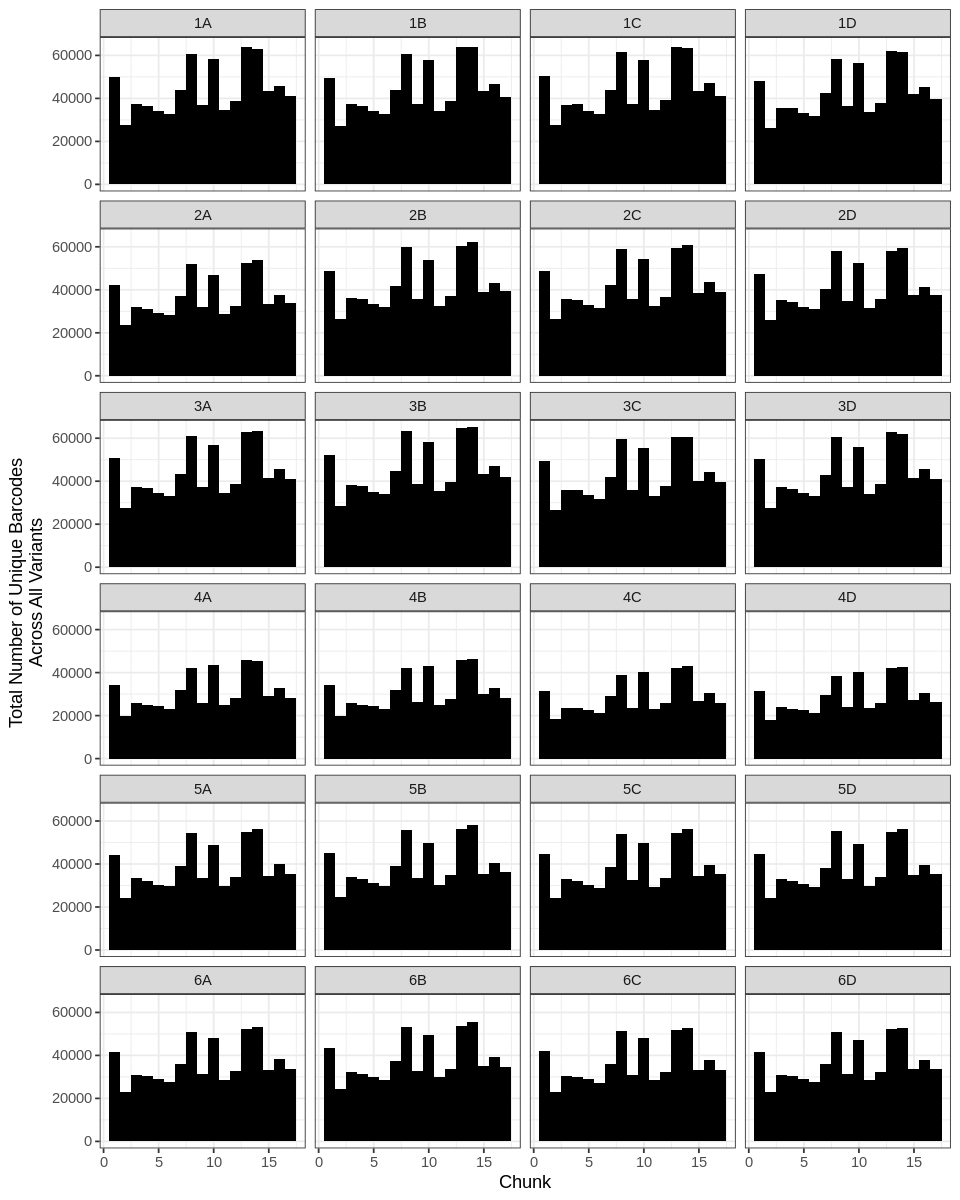

In [12]:
options(repr.plot.width = 8, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = if_else(chunk == "12rc", "12", chunk),
           chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

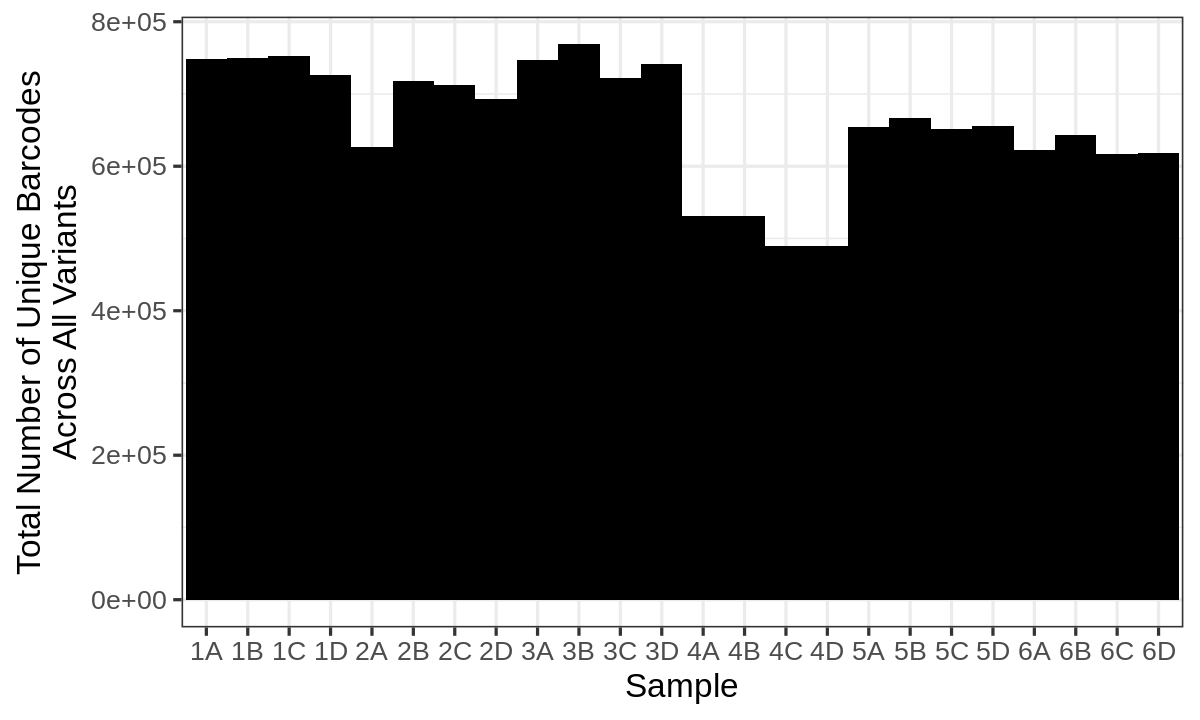

In [13]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

In [33]:
conditions = tibble("condition" = c("IFNalpha100+BMS-9862022e-08",
                                    "IFNalpha1000",
                                    "None0"),
                    "drug" = c("IFNalpha100+BMS-986202",
                               "IFNalpha100",
                               "None"),
                    "conc" = c(2e-8, 0, 0))

In [30]:
prot1 <- dir_ls(path = "../sumstats/TYK2/run8/protocol_1/", regexp = ".*tsv", recurse = TRUE)
names(prot1) <- rep("protocol1", length(prot1))
prot2 <- dir_ls(path = "../sumstats/TYK2/run8/protocol_2/", regexp = ".*tsv", recurse = TRUE)
names(prot2) <- rep("protocol2", length(prot2))

In [32]:
sumstats <- c(prot1, prot2) %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc"), .id = "protocol") %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa)) %>%
    left_join(conditions, by = "condition") %>%
    mutate(condition = str_c(drug, "_", conc))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    select(-group) %>%
    write_tsv("../sumstats/TYK2/run8/tyk2-assay8-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

In [186]:
conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None_0")

sumstats_contr_1 <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None_0",
                                            sumstats = sumstats %>% filter(protocol == "protocol1"))) %>%
    mutate(condition = factor(condition, levels = c("IFNalpha100_0 - None_0",
                                                    "IFNalpha100+BMS-986202_2e-08 - None_0")),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           protocol = "protocol1")

sumstats_contr_2 <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None_0",
                                            sumstats = sumstats %>% filter(protocol == "protocol2"))) %>%
    mutate(condition = factor(condition, levels = c("IFNalpha100_0 - None_0",
                                                    "IFNalpha100+BMS-986202_2e-08 - None_0")),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           protocol = "protocol2")

sumstats_all <- bind_rows(sumstats_contr_1, sumstats_contr_2)
sumstats_all %>% write_tsv("../sumstats/TYK2/run8/tyk2-assay8.tsv")

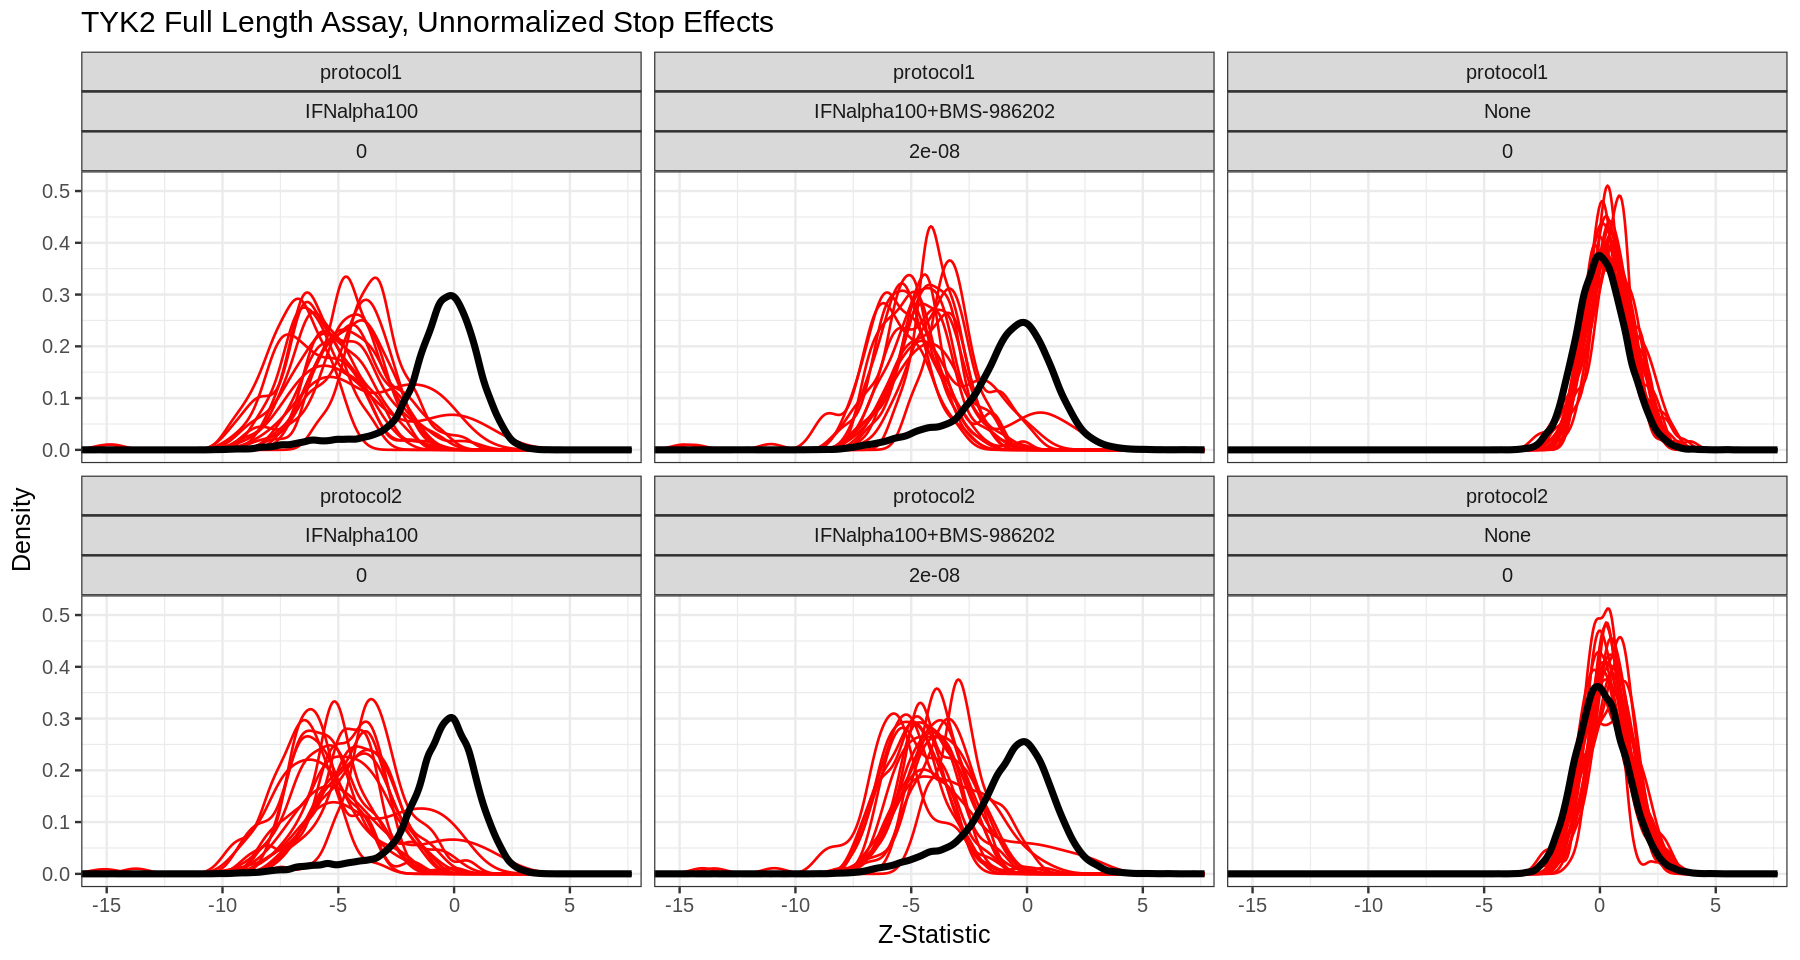

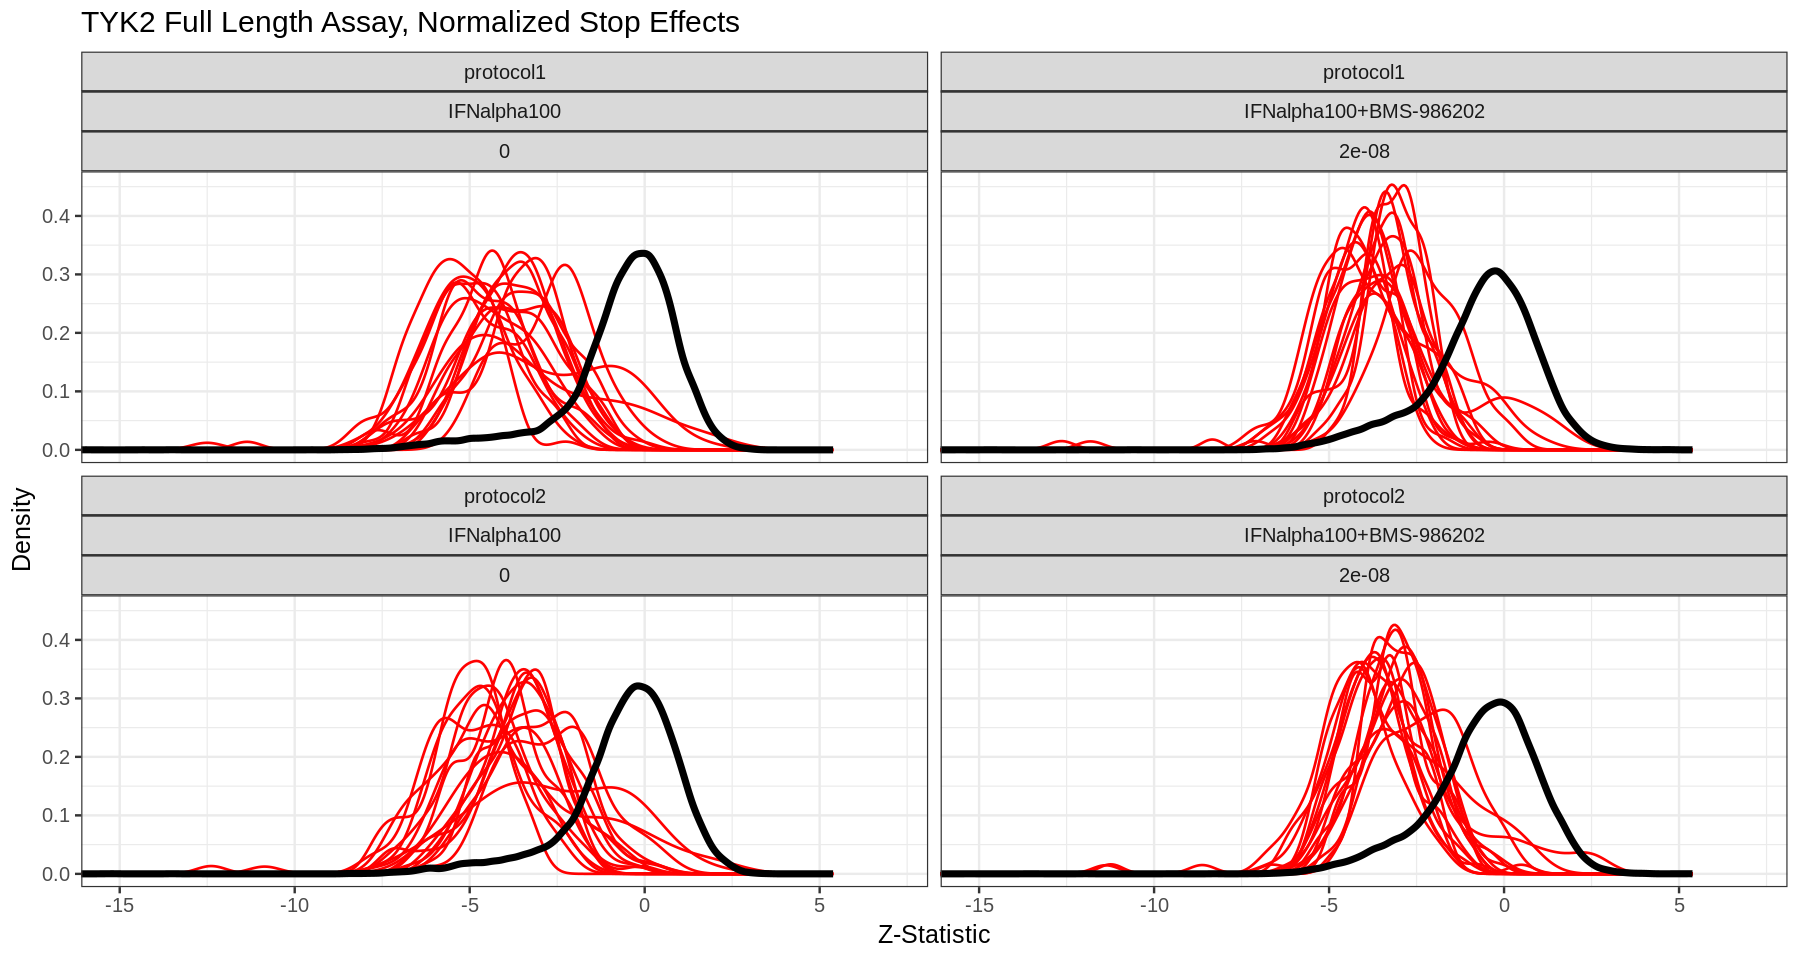

In [40]:
options(repr.plot.width = 15, repr.plot.height = 8)
sumstats %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>% 
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~protocol + drug + conc, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Unnormalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

sumstats_all %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~protocol + drug + conc, ncol = 2) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Normalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [42]:
sumstats_all %>%
    count(protocol,
          drug,
          conc,
          direction = if_else(estimate > 0, "GoF", "LoF"),
          sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n, values_fill = 0) %>%
    arrange(drug, conc) %>%
    kable(type = "markdown", digits = 10)



|protocol  |drug                   |  conc|direction | Non-Significant| Significant (FDR < 0.01)|
|:---------|:----------------------|-----:|:---------|---------------:|------------------------:|
|protocol1 |IFNalpha100            | 0e+00|GoF       |            8749|                        0|
|protocol1 |IFNalpha100            | 0e+00|LoF       |           12596|                     2375|
|protocol2 |IFNalpha100            | 0e+00|GoF       |            8822|                        3|
|protocol2 |IFNalpha100            | 0e+00|LoF       |           12721|                     2172|
|protocol1 |IFNalpha100+BMS-986202 | 2e-08|GoF       |            8155|                       28|
|protocol1 |IFNalpha100+BMS-986202 | 2e-08|LoF       |           13181|                     2356|
|protocol2 |IFNalpha100+BMS-986202 | 2e-08|GoF       |            8511|                       29|
|protocol2 |IFNalpha100+BMS-986202 | 2e-08|LoF       |           13243|                     1935|

### Visualizations <a name="part3"></a>

In [3]:
sumstats <- read_tsv("../sumstats/TYK2/run8/tyk2-assay8-unnormalized.tsv")
sumstats_all <- read_tsv("../sumstats/TYK2/run8/tyk2-assay8.tsv")

Rows: 142314 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): protocol, clone, chunk, condition, aa, version, drug
dbl (8): pos, estimate, std.error, statistic, p.value, dispersion, conc, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94876 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): drug, clone, chunk, aa, version, condition, protocol
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


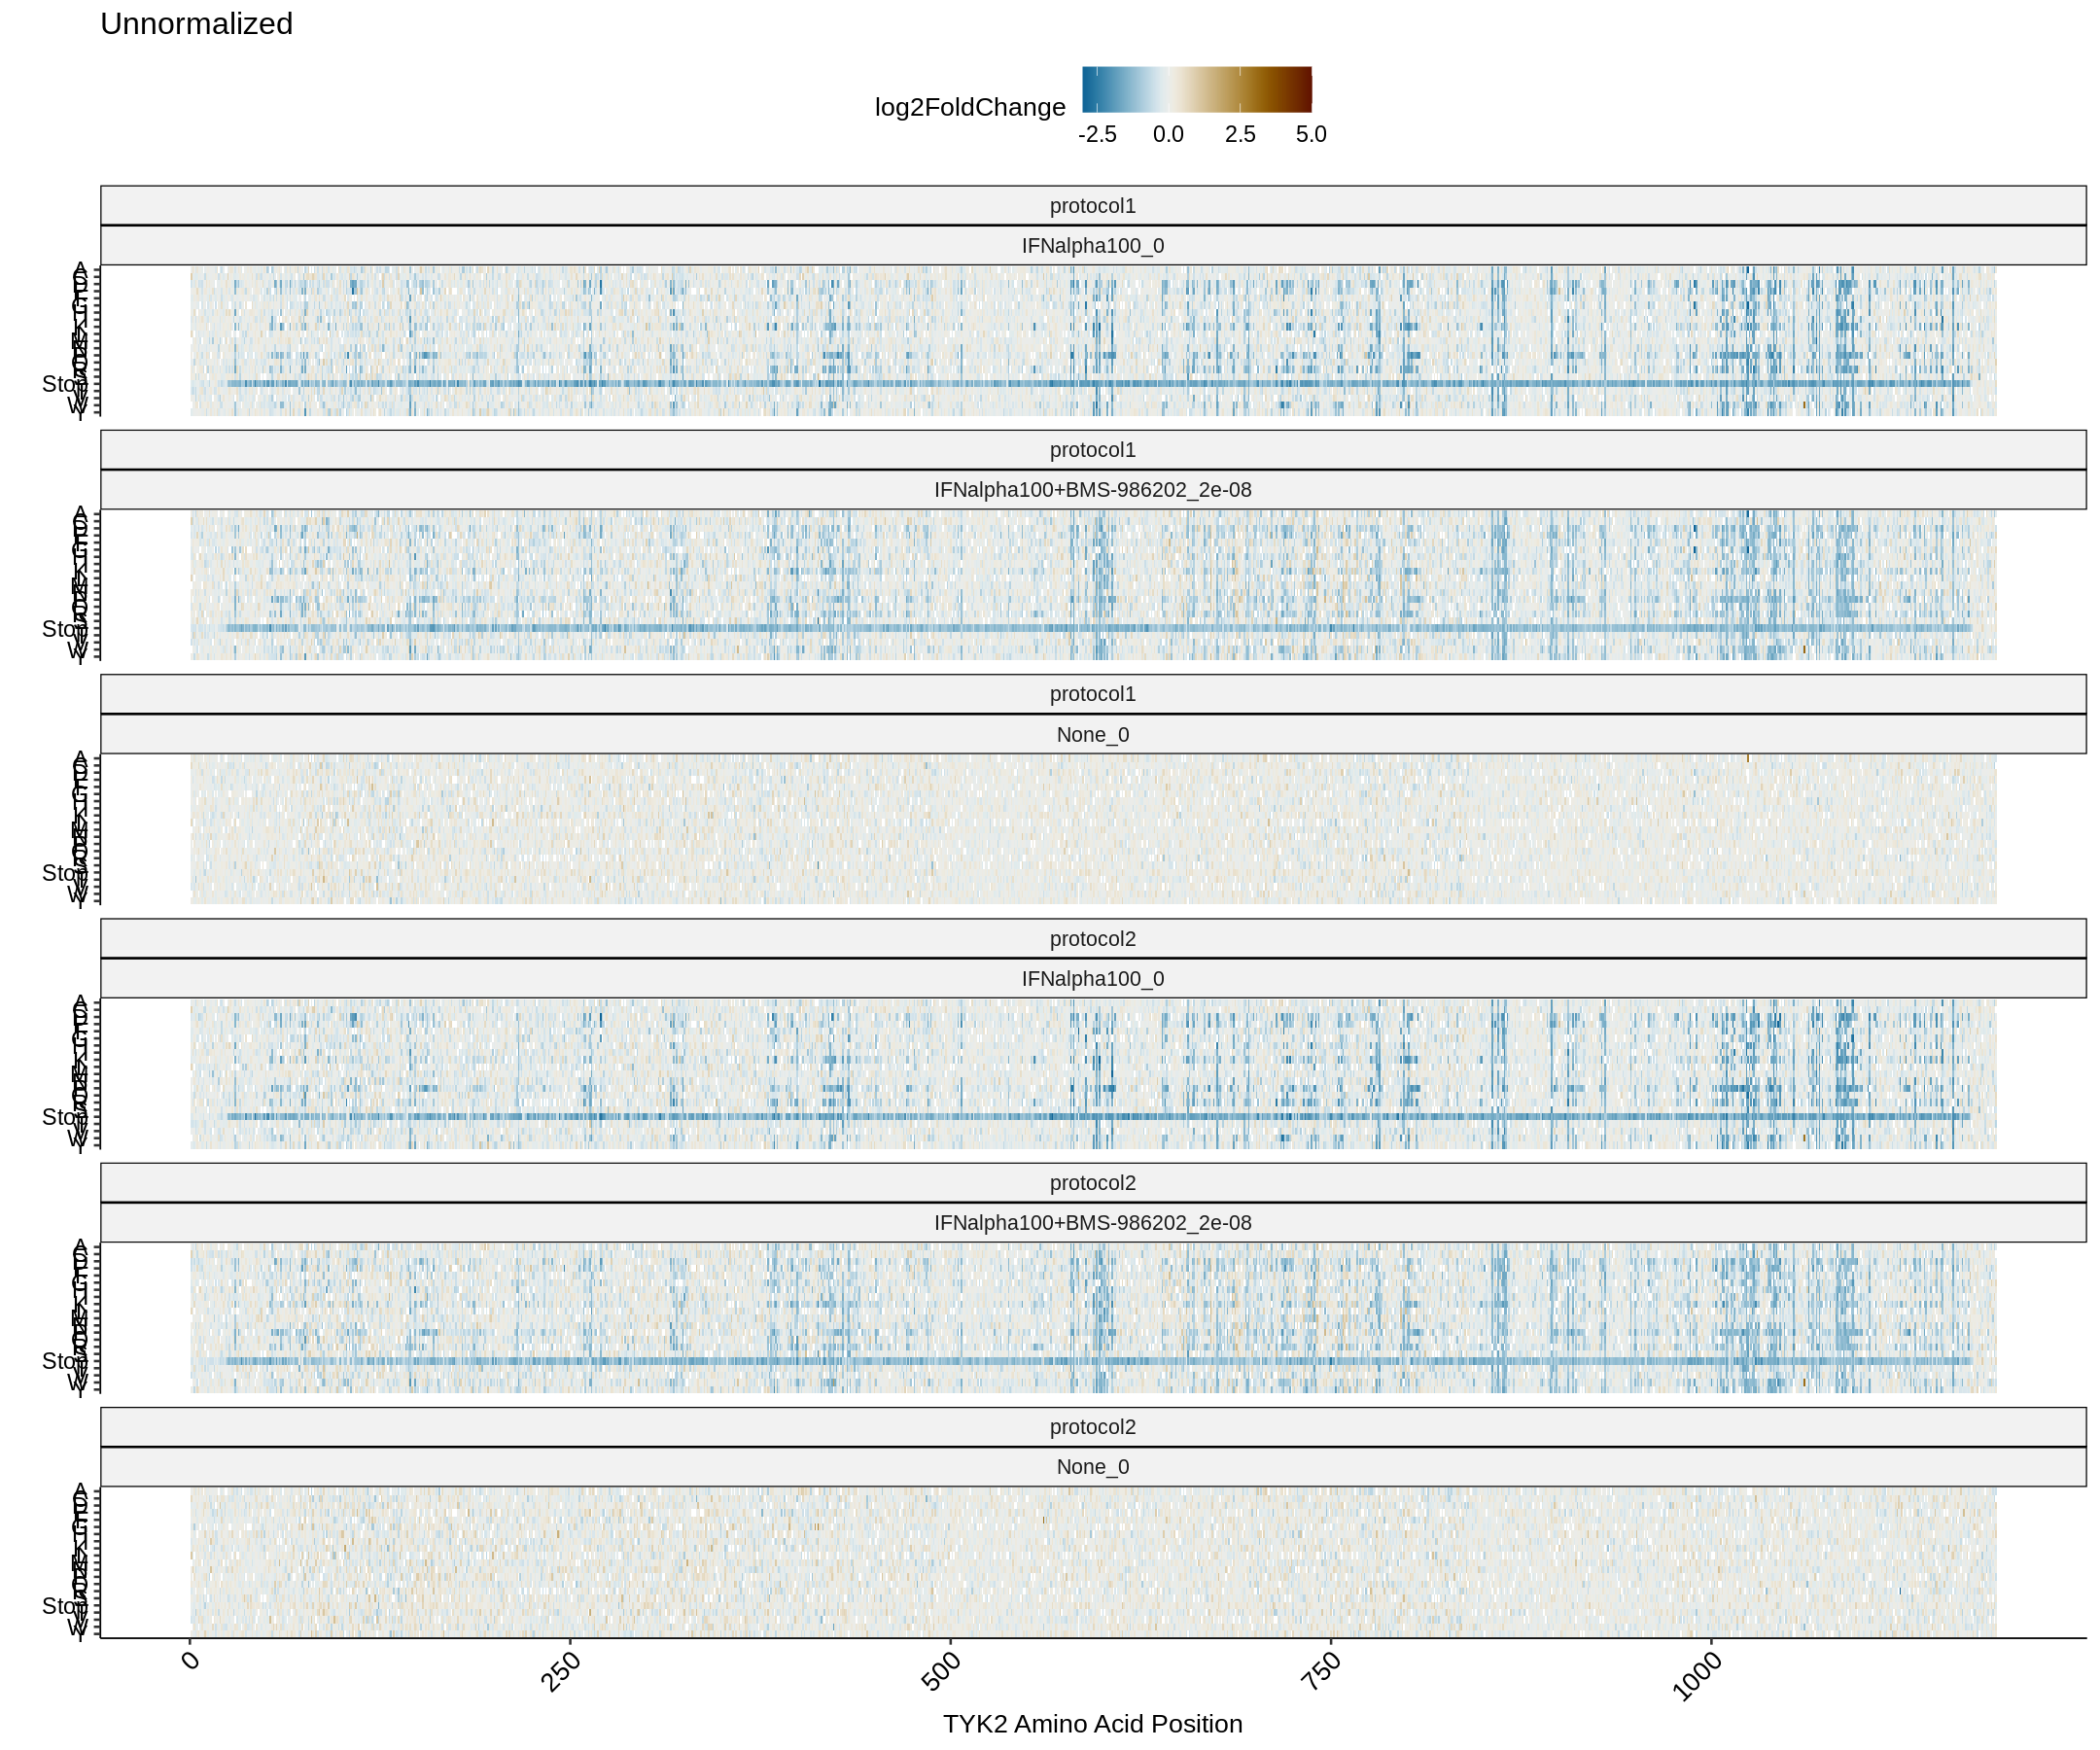

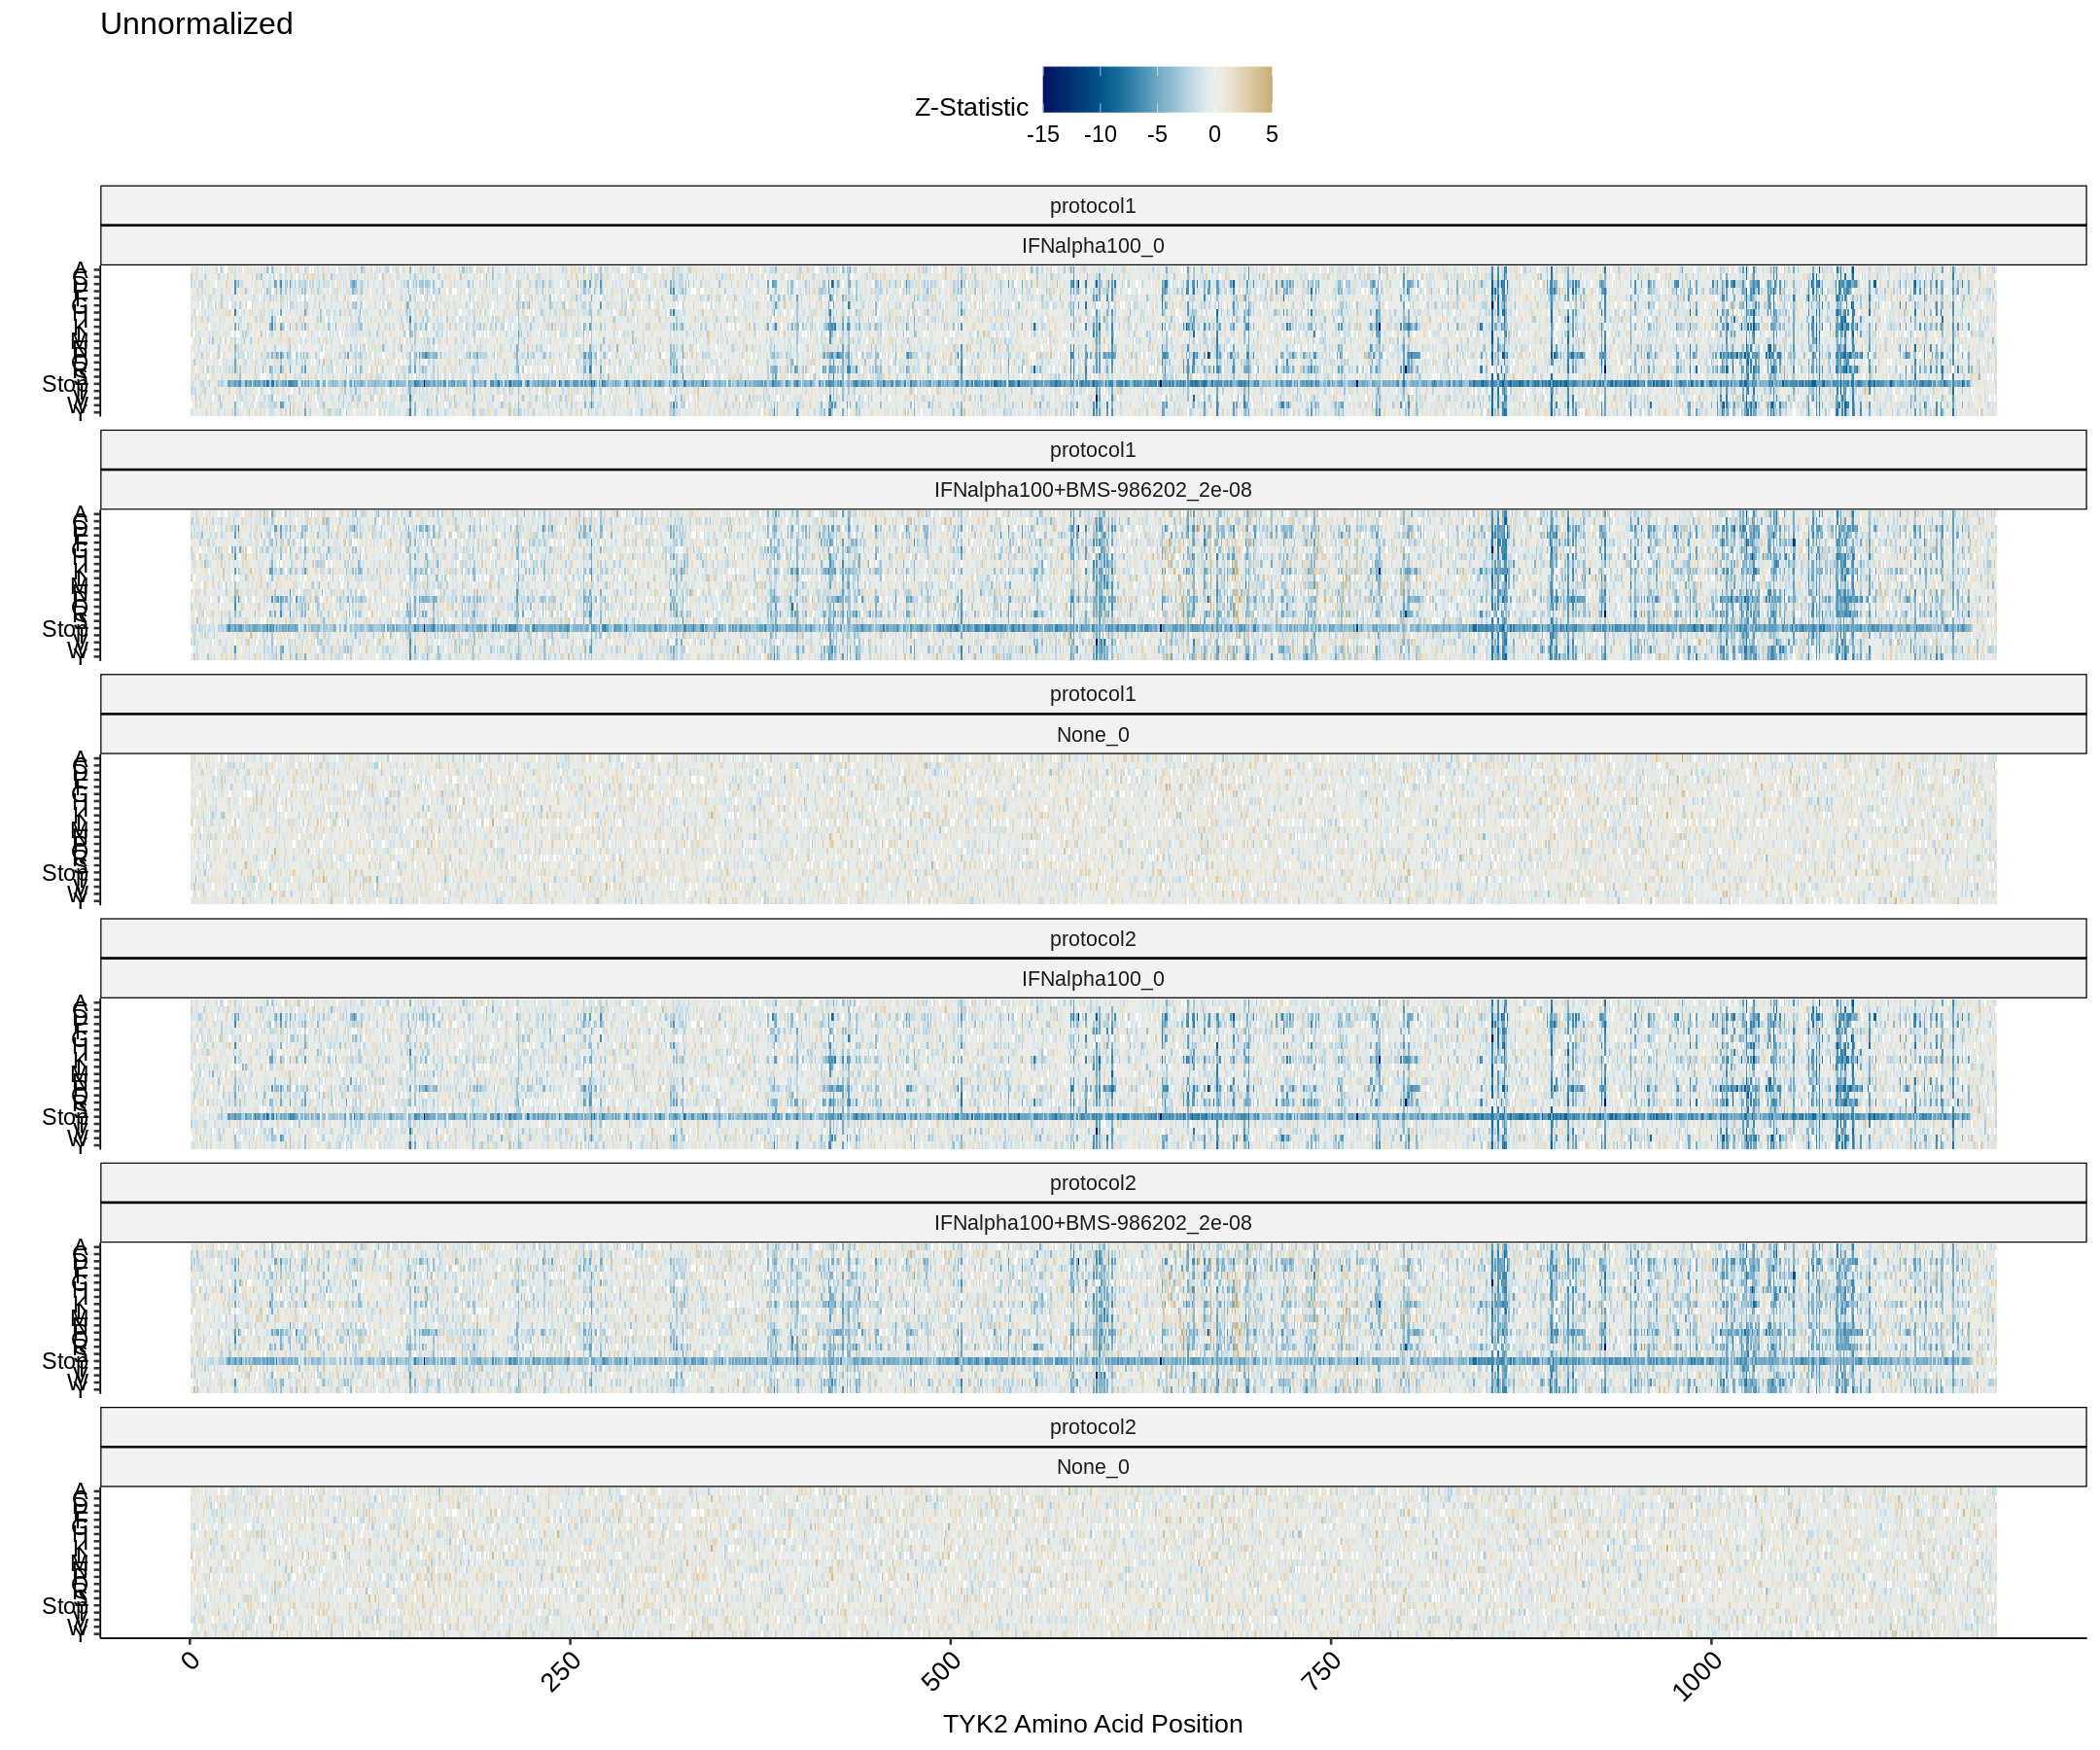

In [43]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~protocol + condition, ncol = 1) +
            ggtitle("Unnormalized")

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~protocol + condition, ncol = 1) +
            ggtitle("Unnormalized")

In [47]:
norm_heat_l2fc <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~protocol + condition, ncol = 1) +
            ggtitle("Normalized to None")

norm_heat_z <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~protocol + condition, ncol = 1) +
            ggtitle("Normalized to None")

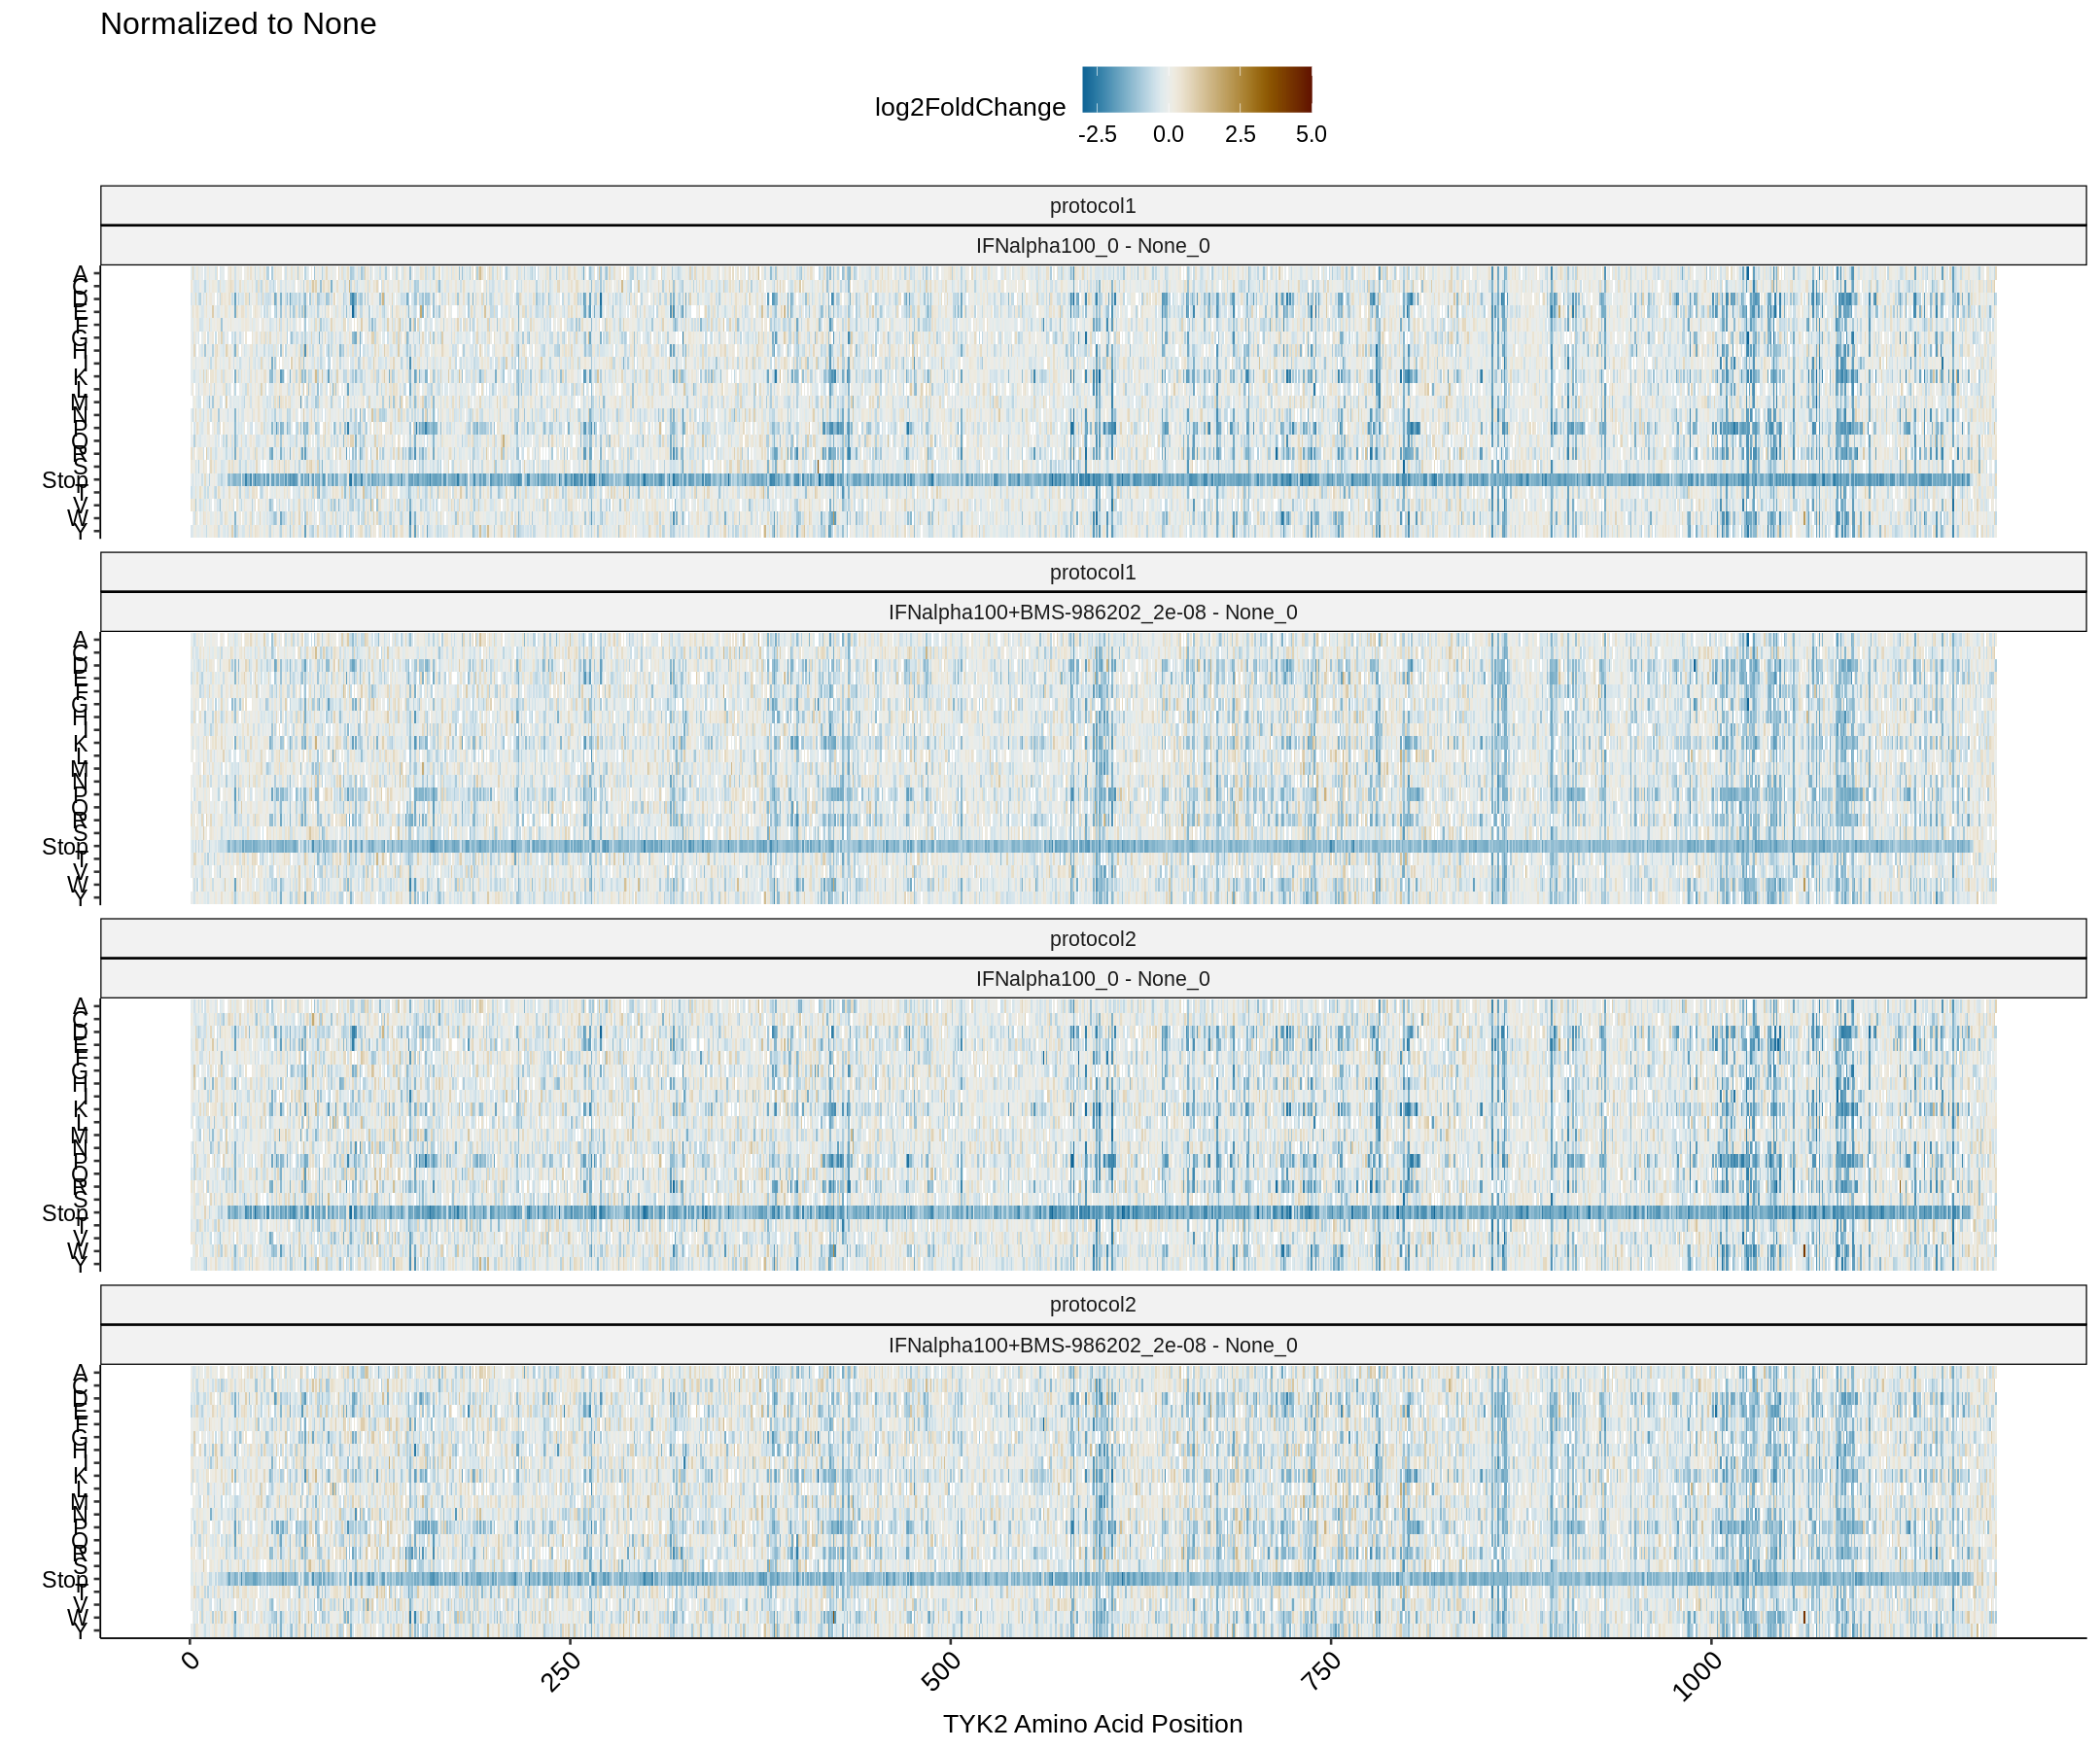

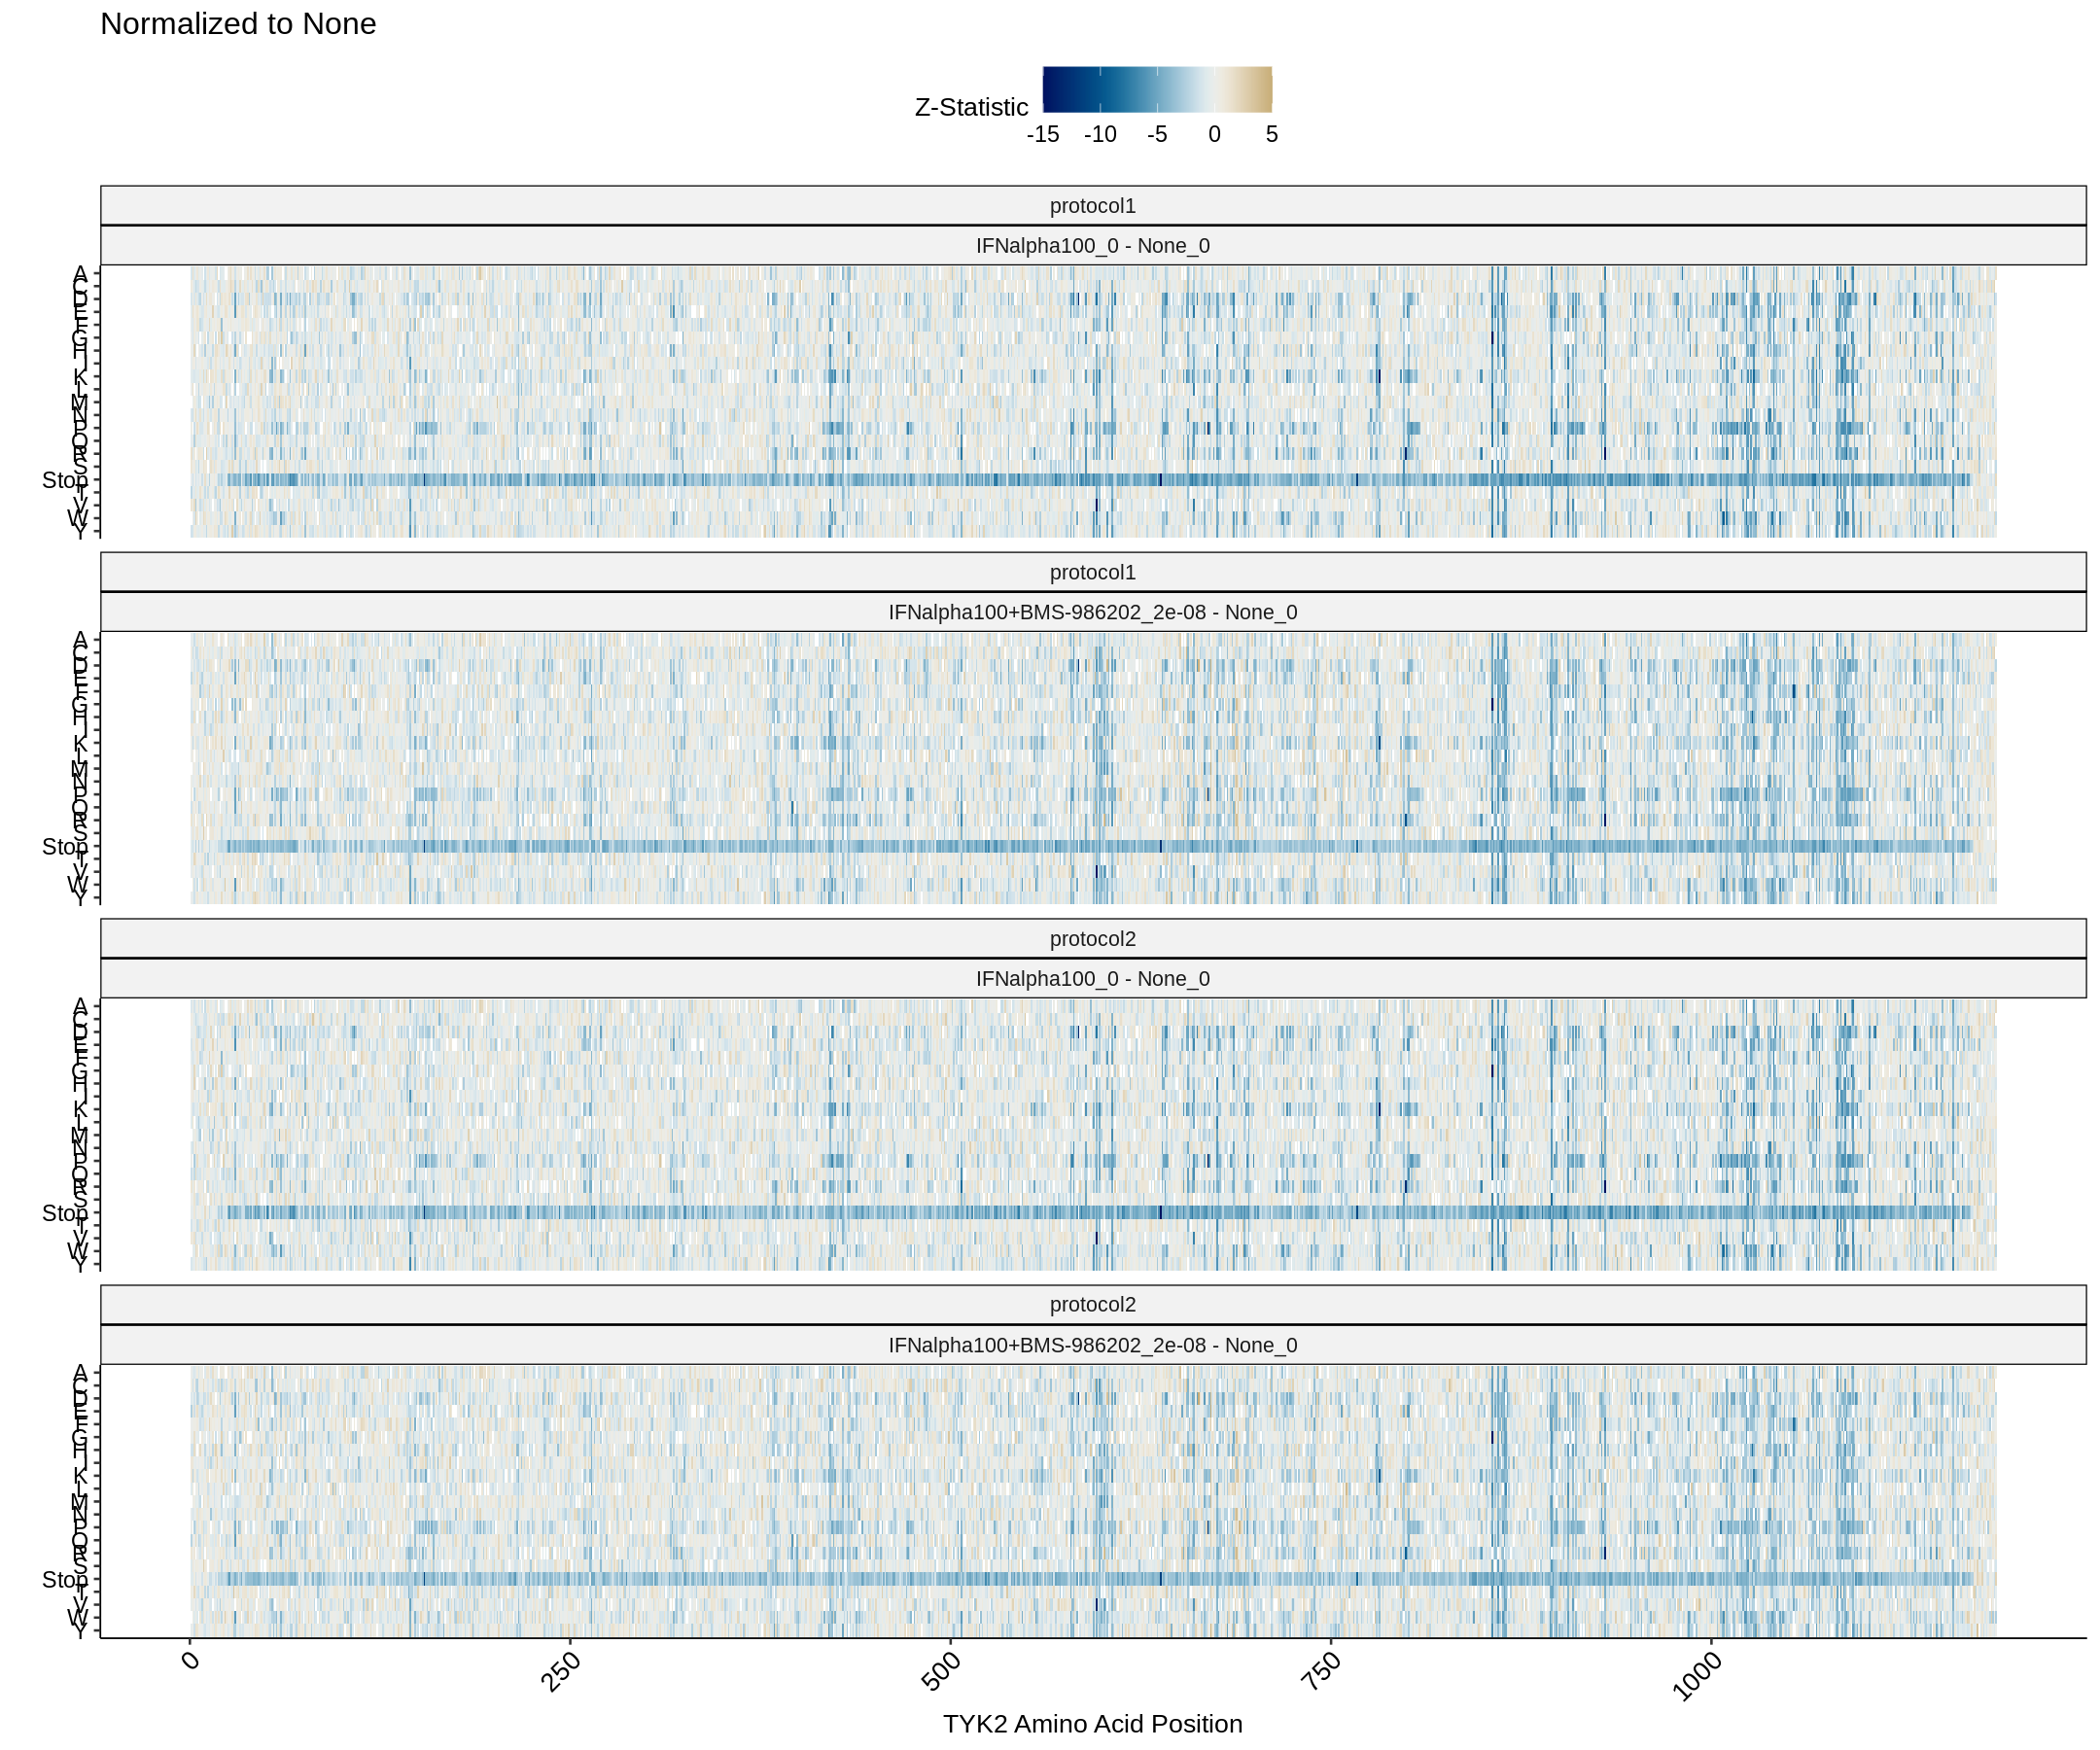

In [48]:
options(repr.plot.width = 18, repr.plot.height = 15)
norm_heat_l2fc
norm_heat_z

### Protocol Comparisons <a name="part4"></a>

The simplest comparison is to plot the same summary statistic from both protocols, across all variants. We can use either the normalized or unnormalized results, and can compare the log2 fold change, z-statistic, and the standard errors:

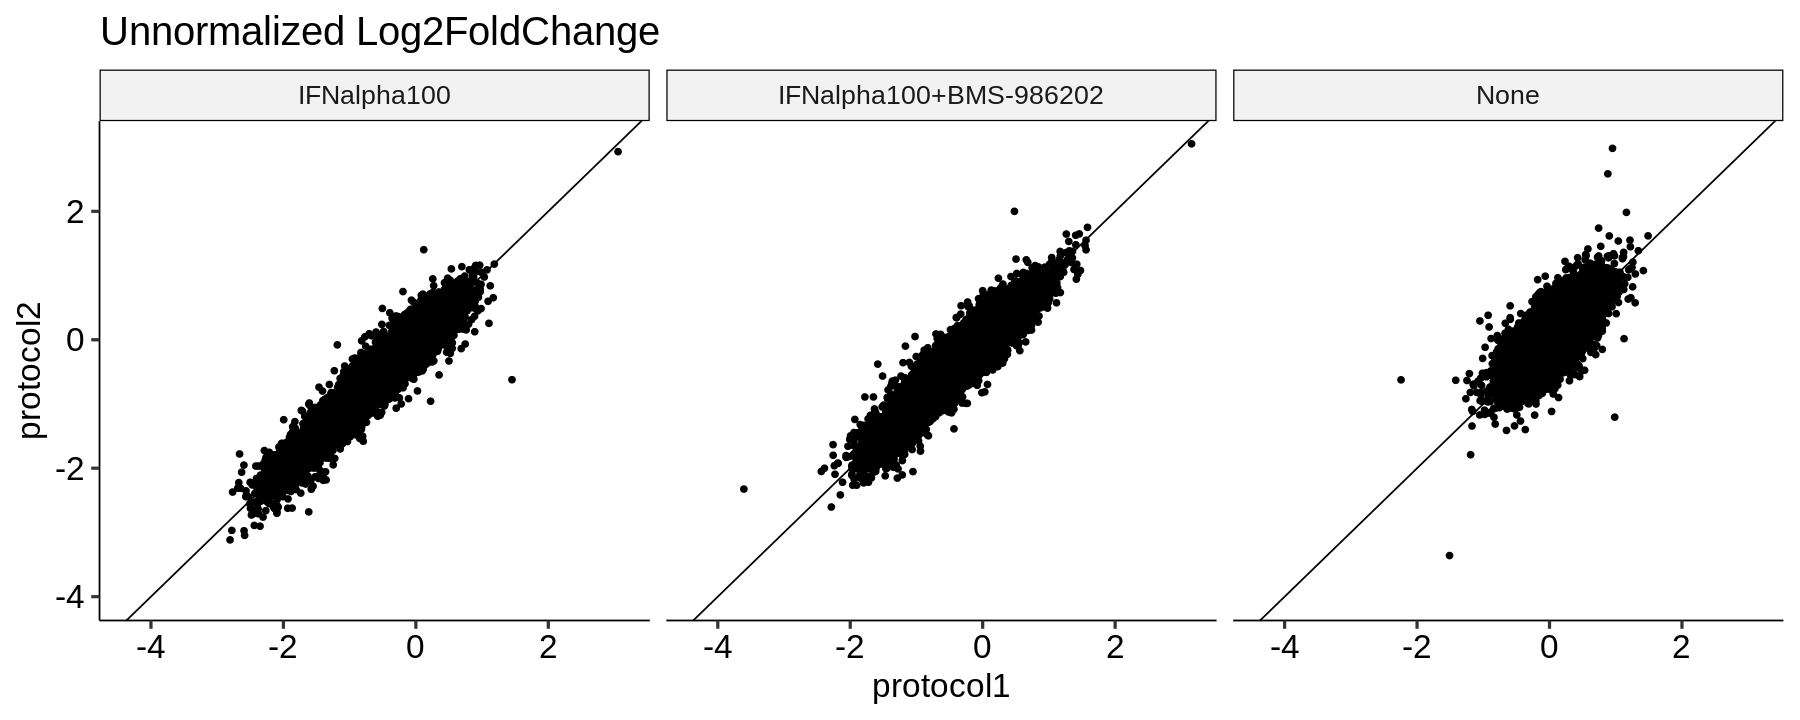

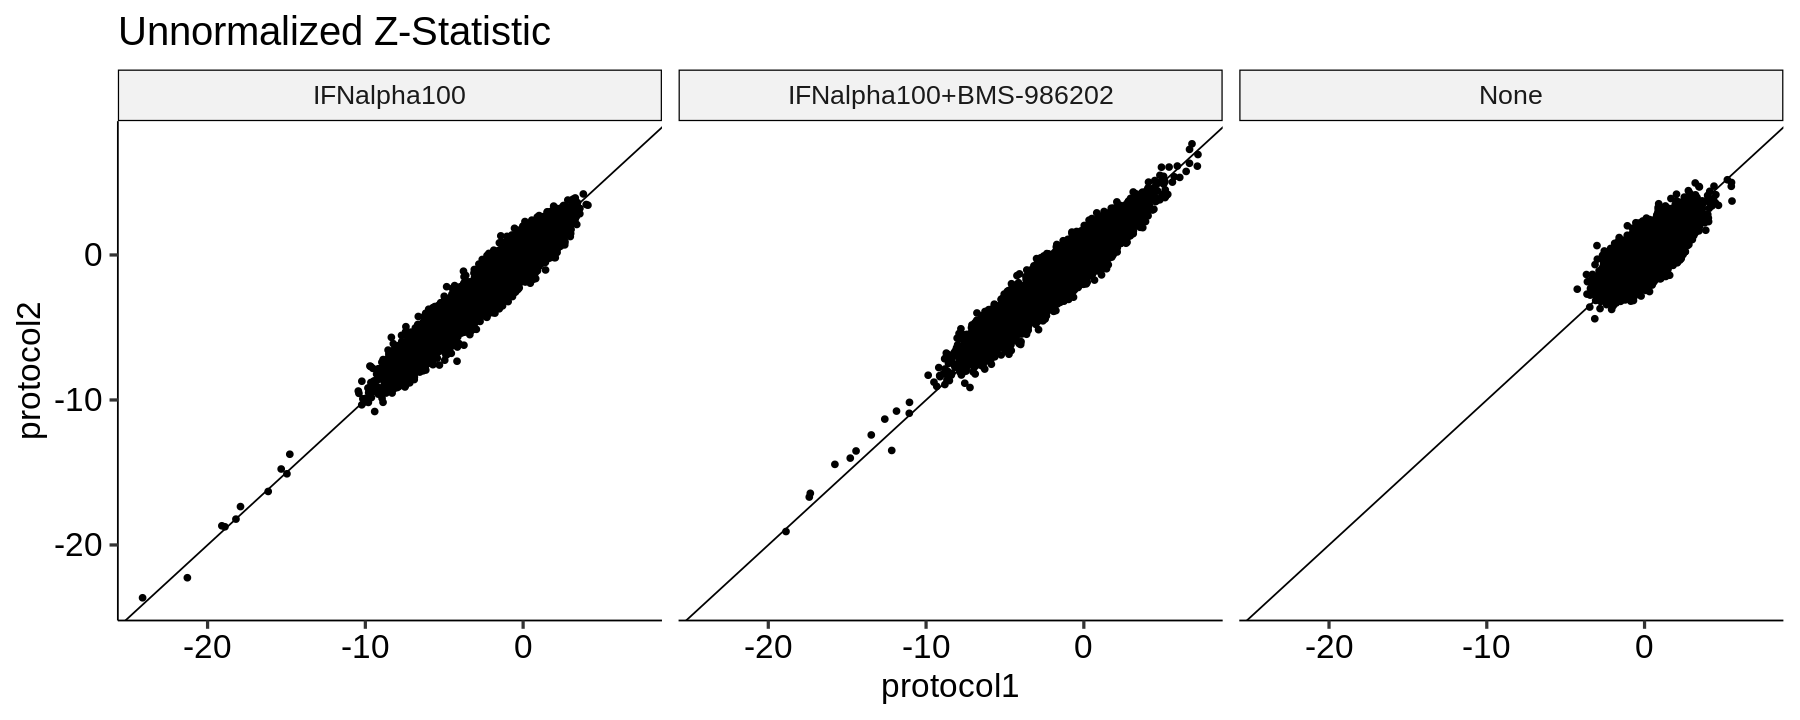

In [60]:
options(repr.plot.width = 15, repr.plot.height = 6, warn = -1)
sumstats %>%
    select(protocol, drug, pos, aa, estimate) %>% 
    rename("log2FoldChange" = "estimate") %>%
    pivot_wider(names_from = protocol, values_from = log2FoldChange, values_fill = NA) %>%
    ggplot() +
        geom_point(aes(x = protocol1, y = protocol2)) +
        theme_pubr(base_size = 20) +
        facet_wrap(~drug ,nrow = 1) +
        ggtitle("Unnormalized Log2FoldChange") +
        geom_abline(slope = 1, intercept = 0)

sumstats %>%
    select(protocol, drug, pos, aa, statistic) %>% 
    pivot_wider(names_from = protocol, values_from = statistic, values_fill = NA) %>%
    ggplot() +
        geom_point(aes(x = protocol1, y = protocol2)) +
        theme_pubr(base_size = 20) +
        facet_wrap(~drug ,nrow = 1)  +
        ggtitle("Unnormalized Z-Statistic") +
        geom_abline(slope = 1, intercept = 0)

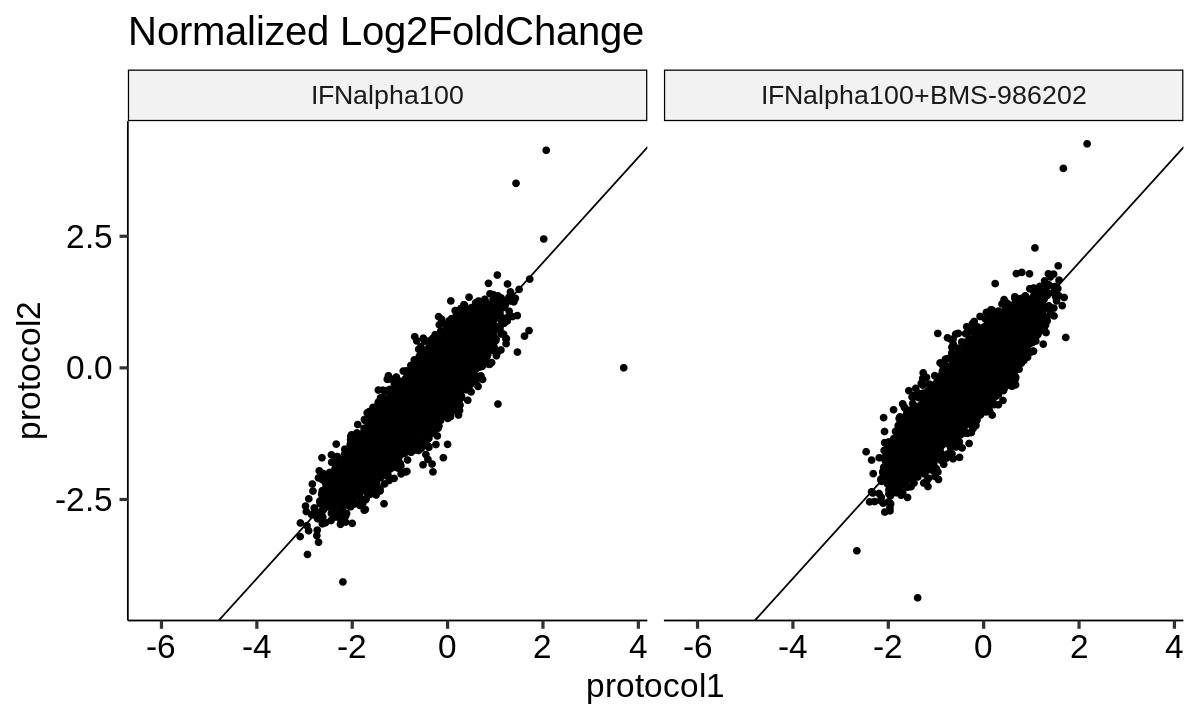

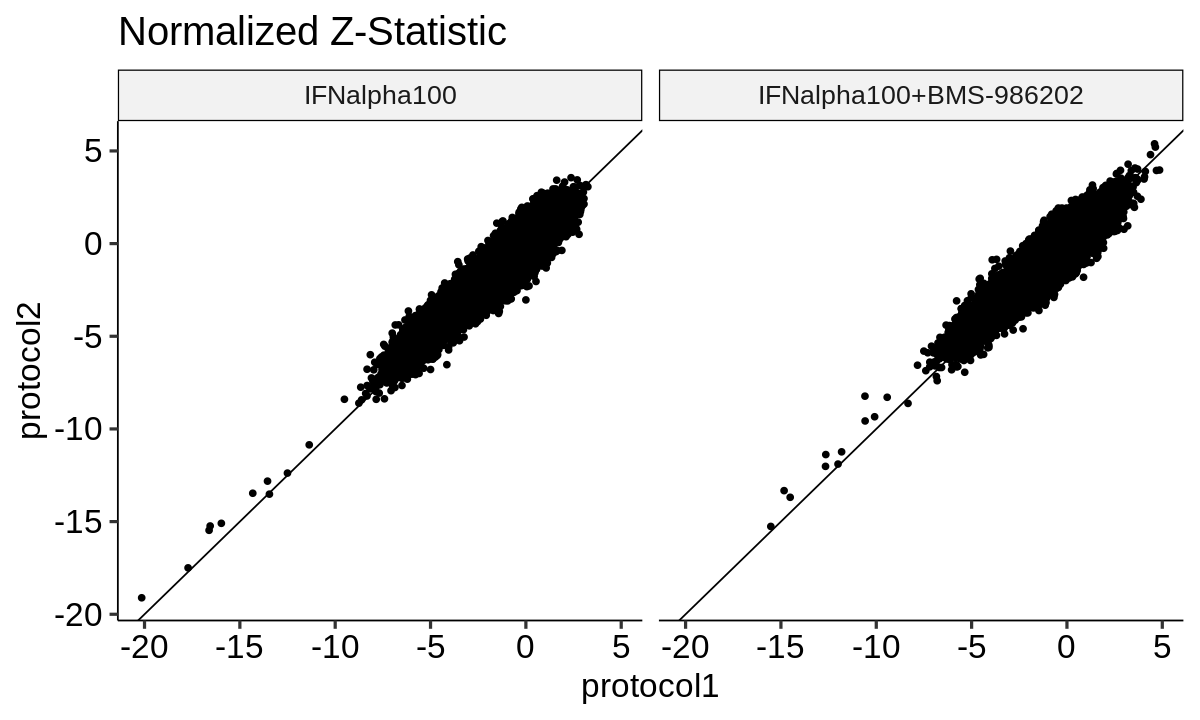

In [157]:
options(repr.plot.width = 10, repr.plot.height = 6, warn = -1)
sumstats_all %>%
    select(protocol, drug, pos, aa, estimate) %>% 
    rename("log2FoldChange" = "estimate") %>%
    pivot_wider(names_from = protocol, values_from = log2FoldChange, values_fill = NA) %>%
    ggplot() +
        geom_point(aes(x = protocol1, y = protocol2)) +
        theme_pubr(base_size = 20) +
        facet_wrap(~drug ,nrow = 1) +
        ggtitle("Normalized Log2FoldChange") +
        geom_abline(slope = 1, intercept = 0)

sumstats_all %>%
    select(protocol, drug, pos, aa, statistic) %>% 
    pivot_wider(names_from = protocol, values_from = statistic, values_fill = NA) %>%
    ggplot() +
        geom_point(aes(x = protocol1, y = protocol2)) +
        theme_pubr(base_size = 20) +
        facet_wrap(~drug ,nrow = 1) +
        ggtitle("Normalized Z-Statistic") +
        geom_abline(slope = 1, intercept = 0)

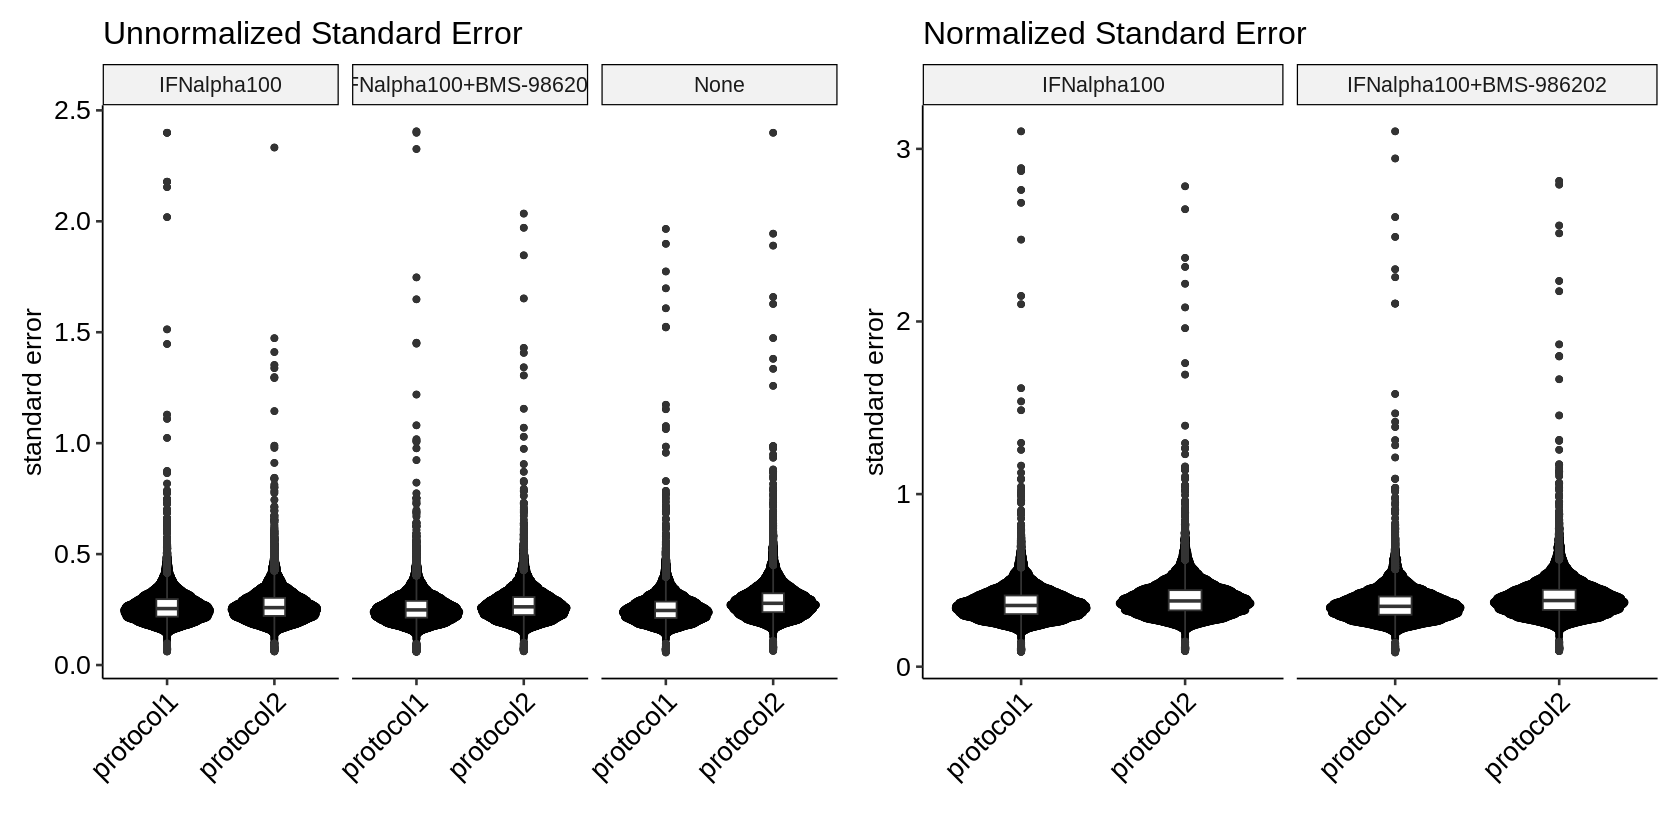

In [158]:
unnorm_se_bee <- ggplot(sumstats) +
    geom_quasirandom(aes(x = protocol, y = std.error)) +
    geom_boxplot(aes(x = protocol, y = std.error), width = 0.2) +
    facet_wrap(~drug) +
    theme_pubr(base_size = 16, x.text.angle = 45) +
    xlab("") + ylab("standard error") +
    ggtitle("Unnormalized Standard Error")

norm_se_bee <- ggplot(sumstats_all) +
    geom_quasirandom(aes(x = protocol, y = std.error)) +
    geom_boxplot(aes(x = protocol, y = std.error), width = 0.2) +
    facet_wrap(~drug) +
    theme_pubr(base_size = 16, x.text.angle = 45) +
    xlab("") + ylab("standard error") +
    ggtitle("Normalized Standard Error")

options(repr.plot.width = 14, repr.plot.height = 7)
unnorm_se_bee + norm_se_bee

This is a little hard to see, so below is the same plot but zoomed in a bit and with just the boxplots:

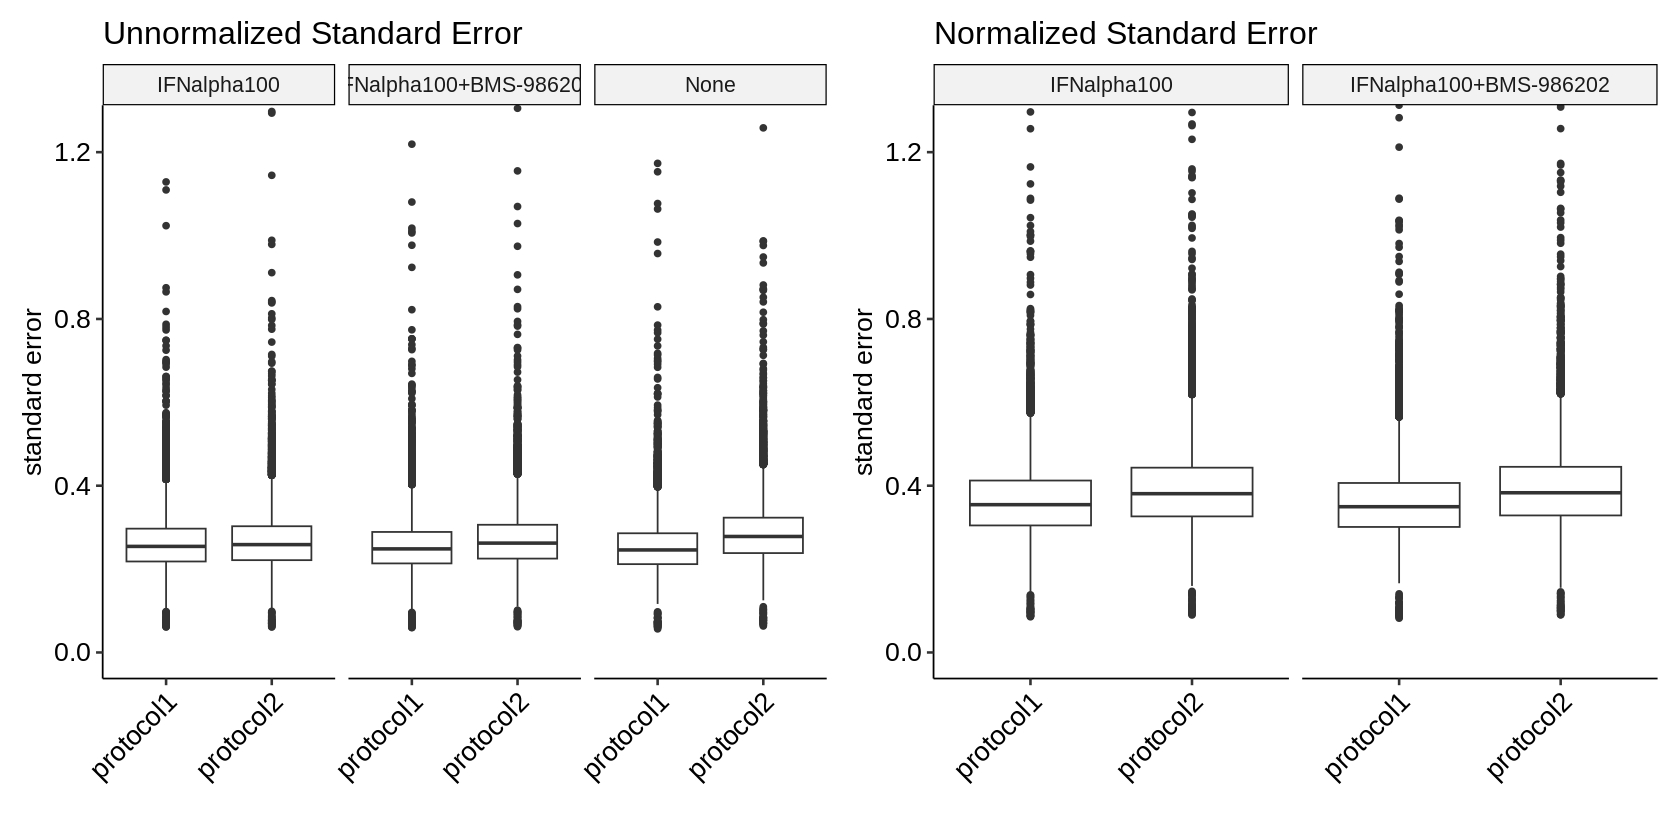

In [159]:
unnorm_se <- ggplot(sumstats) +
    geom_boxplot(aes(x = protocol, y = std.error)) +
    facet_wrap(~drug) +
    theme_pubr(base_size = 16, x.text.angle = 45) +
    xlab("") + ylab("standard error") +
    coord_cartesian(ylim = c(0,1.25)) +
    ggtitle("Unnormalized Standard Error")

norm_se <- ggplot(sumstats_all) +
    geom_boxplot(aes(x = protocol, y = std.error)) +
    facet_wrap(~drug) +
    theme_pubr(base_size = 16, x.text.angle = 45) +
    xlab("") + ylab("standard error") +
    coord_cartesian(ylim = c(0,1.25)) +
    ggtitle("Normalized Standard Error")

options(repr.plot.width = 14, repr.plot.height = 7)
unnorm_se + norm_se

Using the normalized summary statistics, we can count and compare the number of significant effects in either direction:

In [160]:
sumstats_all %>%
    mutate(group = case_when(p.adj < 0.01 & estimate > 0 ~ "GoF",
                             p.adj < 0.01 & estimate < 0 ~ "LoF",
                             TRUE ~ "NS")) %>%
    count(protocol, drug, group) %>%
    pivot_wider(names_from = group, values_from = n, values_fill = 0) %>%
    arrange(drug) %>%
    kable("markdown")



|protocol  |drug                   |  LoF|    NS| GoF|
|:---------|:----------------------|----:|-----:|---:|
|protocol1 |IFNalpha100            | 2375| 21345|   0|
|protocol2 |IFNalpha100            | 2172| 21543|   3|
|protocol1 |IFNalpha100+BMS-986202 | 2356| 21336|  28|
|protocol2 |IFNalpha100+BMS-986202 | 1935| 21754|  29|

For the three sets where both protocols have some significant variants (IFNalpha100 LoF, IFNalpha100+BMS-986202 LoF, and IFNalpha100+BMS-986202 GoF) we can count how many variants are significant in one, the other, or both:

In [161]:
alpha_lof <- sumstats_all %>%
    filter(p.adj < 0.01, estimate < 0, drug == "IFNalpha100") %>%
    select(pos, aa, protocol) %>%
    group_by(pos, aa) %>%
    summarize(group = case_when(length(unique(protocol)) == 2 ~ "Both",
                                length(unique(protocol)) == 1 ~ unique(protocol)), .groups = "keep") %>%
    ungroup() %>%
    distinct() %>%
    count(group) %>%
    rename("IFNalpha100 LoF" = "n")

inhib_lof <- sumstats_all %>%
    filter(p.adj < 0.01, estimate < 0, drug == "IFNalpha100+BMS-986202") %>%
    select(pos, aa, protocol) %>%
    group_by(pos, aa) %>%
    summarize(group = case_when(length(unique(protocol)) == 2 ~ "Both",
                                length(unique(protocol)) == 1 ~ unique(protocol)), .groups = "keep") %>%
    ungroup() %>%
    distinct() %>%
    count(group) %>%
    rename("IFNalpha100+BMS-986202 LoF" = "n")

inhib_gof <- sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha100+BMS-986202") %>%
    select(pos, aa, protocol) %>%
    group_by(pos, aa) %>%
    summarize(group = case_when(length(unique(protocol)) == 2 ~ "Both",
                                length(unique(protocol)) == 1 ~ unique(protocol)), .groups = "keep") %>%
    ungroup() %>%
    distinct() %>%
    count(group) %>%
    rename("IFNalpha100+BMS-986202 GoF" = "n")

In [162]:
alpha_lof %>%
    inner_join(inhib_lof, by = join_by(group)) %>%
    inner_join(inhib_gof, by = join_by(group)) %>%
    kable("markdown")



|group     | IFNalpha100 LoF| IFNalpha100+BMS-986202 LoF| IFNalpha100+BMS-986202 GoF|
|:---------|---------------:|--------------------------:|--------------------------:|
|Both      |            1989|                       1683|                         16|
|protocol1 |             386|                        673|                         12|
|protocol2 |             183|                        252|                         13|

For the IFNalpha100+BMS-986202 GoF variants in particular, we can examine the underlying summary statistics more closely for those that are significant in either or both protocols:

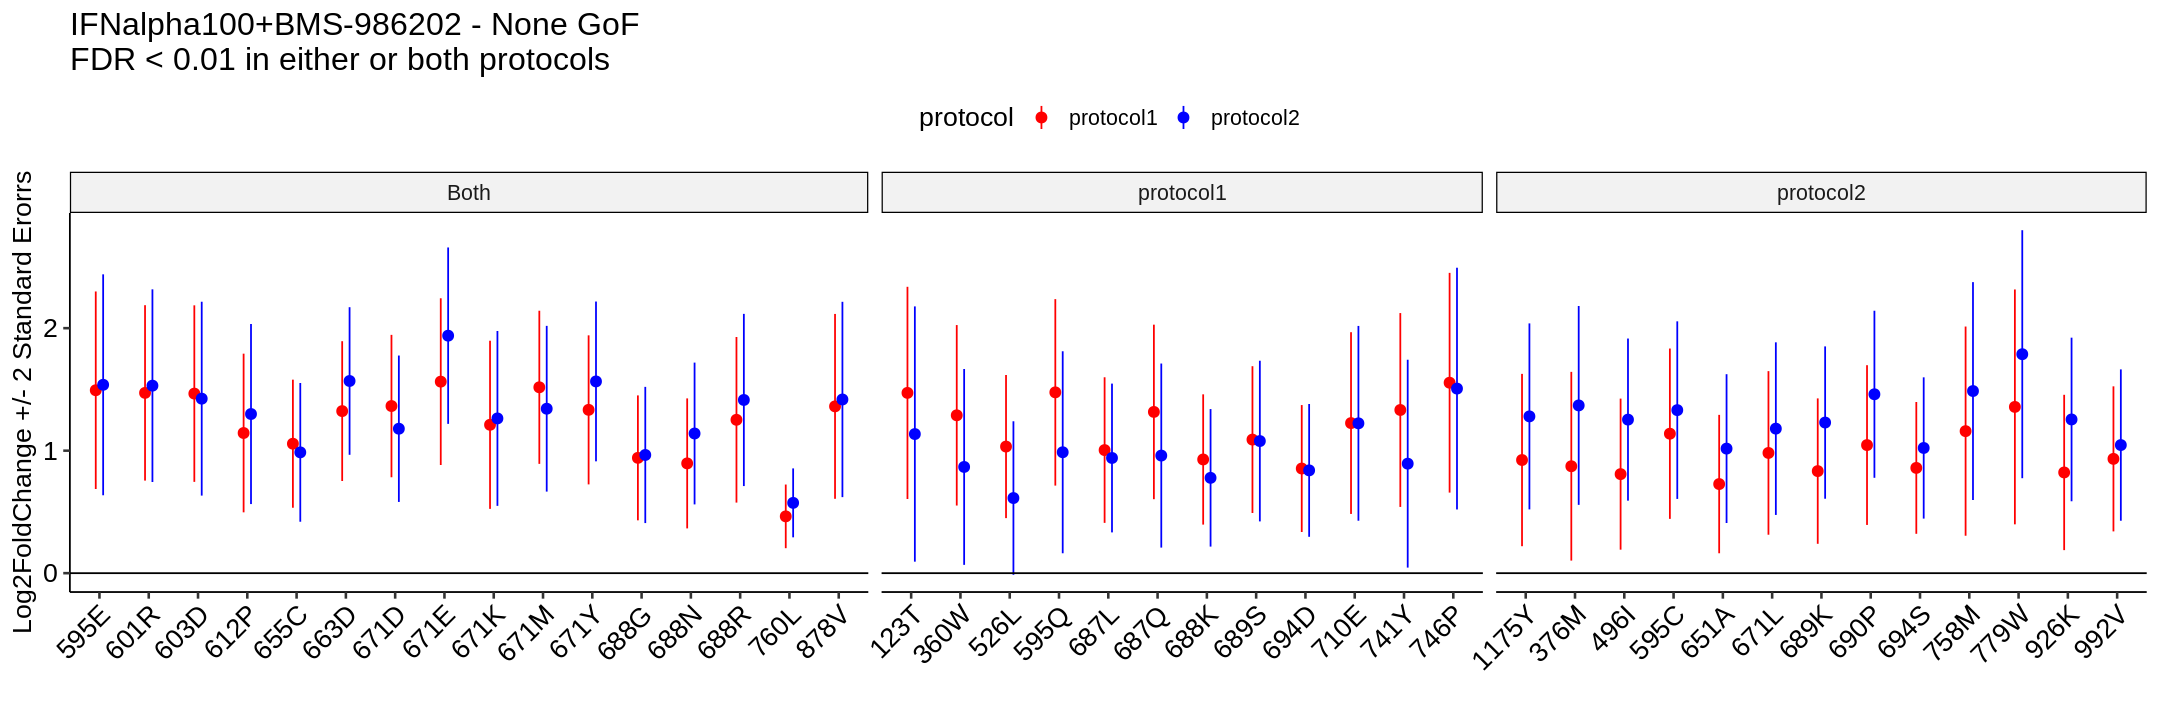

In [9]:
gof_set <- sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha100+BMS-986202") %>%
    select(pos, aa, protocol) %>%
    group_by(pos, aa) %>%
    summarize(group = case_when(length(unique(protocol)) == 2 ~ "Both",
                                length(unique(protocol)) == 1 ~ unique(protocol)),
              .groups = "keep") %>%
    distinct()

options(repr.plot.width = 18, repr.plot.height = 6)
sumstats_all %>%
    filter(drug == "IFNalpha100+BMS-986202") %>%
    inner_join(gof_set, by = c("pos", "aa")) %>%
    
    ggplot() +
        geom_pointrange(aes(x = str_c(pos, aa), y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error,
                            color = protocol), position = position_dodge(width = 0.3)) +
        geom_hline(yintercept = 0) +
        theme_pubr(x.text.angle = 45, base_size = 16) +
        facet_grid(cols = vars(group), scales = "free_x", space = "free") +
        scale_color_manual(values = c("protocol1" = "red", "protocol2" = "blue")) +
        xlab("") + ylab("Log2FoldChange +/- 2 Standard Erorrs") +
        ggtitle("IFNalpha100+BMS-986202 - None GoF\nFDR < 0.01 in either or both protocols")

### Potentiation Comparisons <a name="part5"></a>

In this dataset, we care mainly about evaluating potentiation effects. To do so, we don't normalize to "None", but instead subtract the IFN-alpha condition from the IFN-alpha + BMS condition within each protocol separately. Comparing the results will let us evaluate whether we identify similar potentiators in both datasets. The simple heatmap below shows which variants are significant in both or one protocol: 

In [4]:
potentiation_1 <- compute_difference(test = "IFNalpha100+BMS-986202_2e-08",
                                     control = "IFNalpha100_0",
                                     sumstats = sumstats %>% filter(protocol == "protocol1")) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           protocol = "protocol1")

potentiation_2 <- compute_difference(test = "IFNalpha100+BMS-986202_2e-08",
                                     control = "IFNalpha100_0",
                                     sumstats = sumstats %>% filter(protocol == "protocol2")) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           protocol = "protocol2")

sumstats_potentiation <- bind_rows(potentiation_1, potentiation_2)

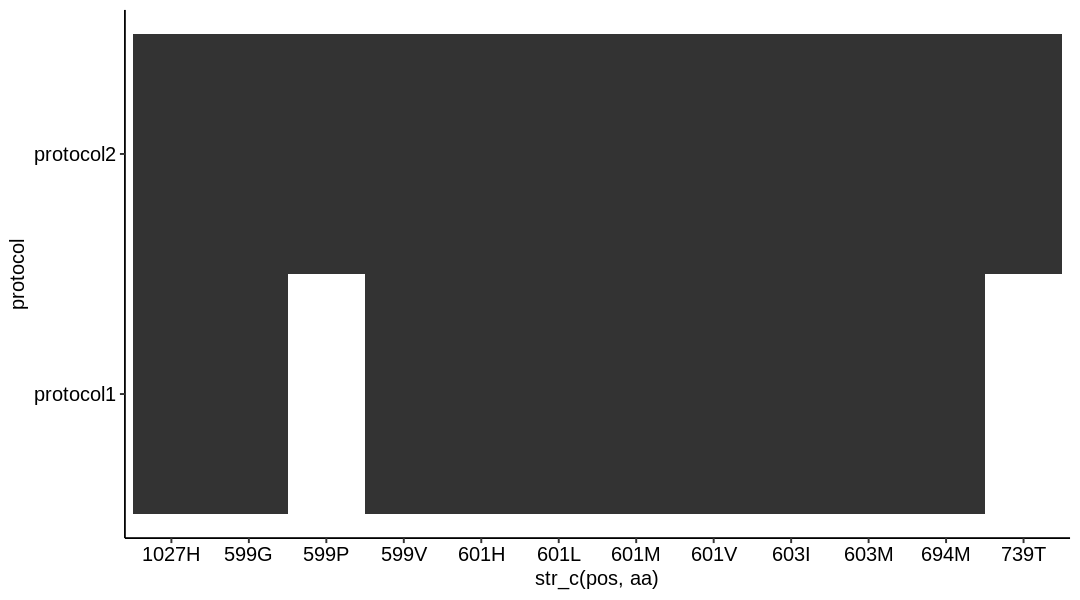

In [182]:
options(repr.plot.width = 9, repr.plot.height = 5)
sumstats_potentiation %>%
    filter(p.adj < 0.01, estimate < 0) %>%
    select(pos, aa, protocol) %>%
    ggplot() +
        geom_tile(aes(y = protocol, x = str_c(pos, aa))) +
        theme_pubr()

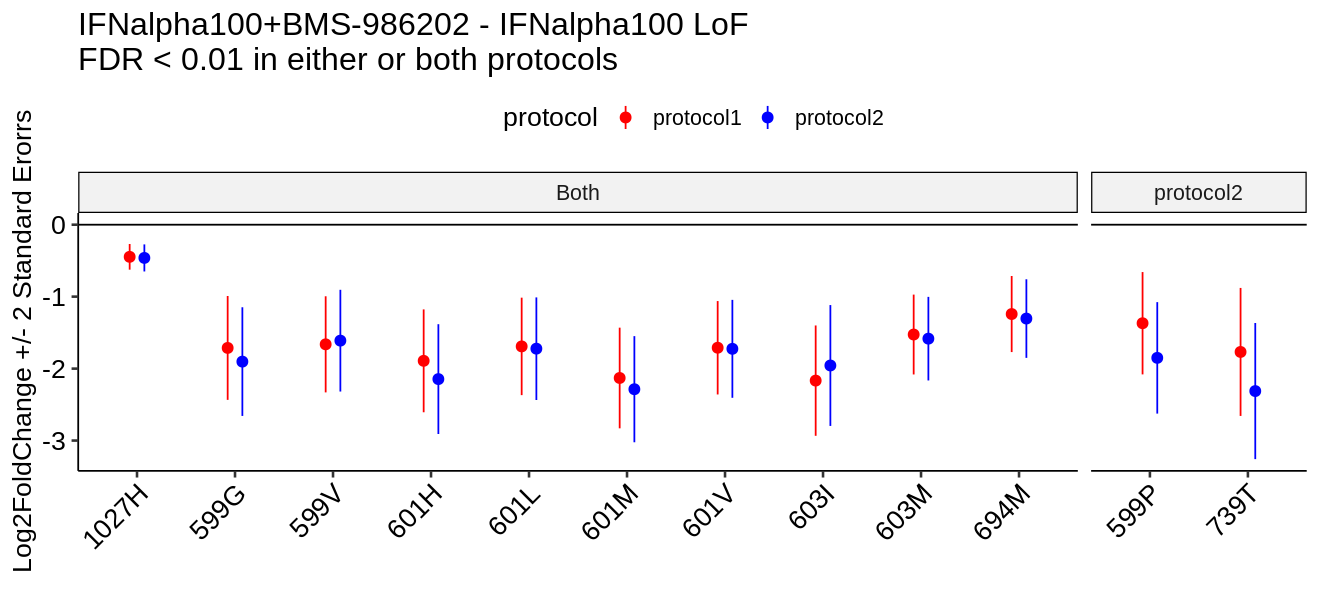

In [8]:
options(repr.plot.width = 11, repr.plot.height = 5, warn = -1)

sig_vars <- sumstats_potentiation %>%
    filter(p.adj < 0.01, estimate < 0) %>%
    select(pos, aa, protocol) %>%
    group_by(pos, aa) %>%
    summarize(group = case_when(length(unique(protocol)) == 2 ~ "Both",
                                length(unique(protocol)) == 1 ~ unique(protocol)),
              .groups = "keep") %>%
    distinct()

sumstats_potentiation %>%
    inner_join(sig_vars, by = c("pos", "aa")) %>%
    ggplot() +
        geom_pointrange(aes(x = str_c(pos, aa), y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error,
                            color = protocol), position = position_dodge(width = 0.3)) +
        geom_hline(yintercept = 0) +
        theme_pubr(x.text.angle = 45, base_size = 16) +
        scale_color_manual(values = c("protocol1" = "red", "protocol2" = "blue")) +
        xlab("") + ylab("Log2FoldChange +/- 2 Standard Erorrs") +
        ggtitle("IFNalpha100+BMS-986202 - IFNalpha100 LoF\nFDR < 0.01 in either or both protocols") +
        facet_grid(cols = vars(group), scales = "free_x", space = "free")